
# **Mask Detection**
### **Project Goal**

* **During these periods Covid 19 spreads rapidly, Wearing masks has become a big part of our lives.** 
* **Organizations and countries are looking for a way to track mask wearing using artificial intelligence.** 
* **The following project shows the feasibility of the solution and examines a number of different models and finally presents their results.**





### **Runs result on Weights & Biases**
* **[Weights & Biases account](https://wandb.ai/liortoledano/Face%20mask%20detection?workspace=user-liortoledano)**

# **Imports**

In [1]:
DEBUG = False

# Data Manipulation
import pandas as pd

# Numerical Analysis
import numpy as np

# Data Visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Data Extraction
import glob
from xml.etree import ElementTree


from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch

import torch, torchvision
import torch.nn as nn
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import AnchorGenerator, FastRCNNPredictor, FasterRCNN
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models import mobilenet_v2, resnet101, vgg19


from PIL import Image
import time, random, os, cv2, ast, numba
from numba import jit
from tqdm.autonotebook import tqdm
from pprint import pprint
import sys


# Saving the data in Coco format

In [2]:
!git clone https://github.com/roboflow-ai/voc2coco


Cloning into 'voc2coco'...
remote: Enumerating objects: 416, done.
remote: Total 416 (delta 0), reused 0 (delta 0), pack-reused 416
Receiving objects: 100% (416/416), 209.27 KiB | 948.00 KiB/s, done.
Resolving deltas: 100% (379/379), done.


In [3]:
annotations_directory = '../input/face-mask-detection/annotations'
images_directory = '../input/face-mask-detection/images'
ids = []
imgs_dir = list(sorted(glob.glob(images_directory + '/*.png')))
labels_dir = list(sorted(glob.glob(annotations_directory + "/*.xml")))
for path in labels_dir:
    ids.append((path.split('/')[-1]).split('.')[0])

In [4]:
y_train, y_test = train_test_split(ids, test_size=0.02, random_state=42)

In [5]:
y_train, y_val = train_test_split(y_train, test_size=0.2, random_state=42)

In [6]:
print(f'Images in the Train - {len(y_train)}, Validation - {len(y_val)}, Test - {len(y_test)}')

Images in the Train - 668, Validation - 167, Test - 18


In [7]:
with open('train_ann_list.txt', mode='wt', encoding='utf-8') as myfile:
    myfile.write('\n'.join(y_train))
    
with open('val_ann_list.txt', mode='wt', encoding='utf-8') as myfile:
    myfile.write('\n'.join(y_val))
    
with open('test_ann_list.txt', mode='wt', encoding='utf-8') as myfile:
    myfile.write('\n'.join(y_test))

In [8]:
#!cat list.txt

In [9]:
labels2File = 'back_ground \nwith_mask \nwithout_mask \nmask_weared_incorrect '
file = open('labels.txt', 'w')
file.write(labels2File)
file.close()
!cat labels.txt

back_ground 
with_mask 
without_mask 
mask_weared_incorrect 

**Creating Train/Validation/Test Coco annotations format**

In [10]:
!python ./voc2coco/voc2coco.py \
    --ann_dir ../input/face-mask-detection/annotations \
    --ann_ids ./train_ann_list.txt \
    --labels ./labels.txt \
    --output ./train.json \
    --ext xml

Start converting !
100%|████████████████████████████████████████| 668/668 [00:01<00:00, 364.93it/s]


In [11]:
!python ./voc2coco/voc2coco.py \
    --ann_dir ../input/face-mask-detection/annotations \
    --ann_ids ./val_ann_list.txt \
    --labels ./labels.txt \
    --output ./val.json \
    --ext xml

Start converting !
100%|████████████████████████████████████████| 167/167 [00:00<00:00, 370.73it/s]


In [12]:
!python ./voc2coco/voc2coco.py \
    --ann_dir ../input/face-mask-detection/annotations \
    --ann_ids ./test_ann_list.txt \
    --labels ./labels.txt \
    --output ./test.json \
    --ext xml

Start converting !
100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 373.89it/s]


**Check output**

In [13]:
!cut -f -4 -d , ./train.json

{"images": [{"file_name": "maksssksksss38.png", "height": 285, "width": 400, "id": 38}


In [14]:
# Download TorchVision repo to use some files from
# references/detection
!pip install pycocotools --quiet
!git init
!git clone https://github.com/pytorch/vision.git
#!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Initialized empty Git repository in /kaggle/working/.git/
Cloning into 'vision'...
remote: Enumerating objects: 52619, done.
remote: Counting objects: 100% (18089/18089), done.
remote: Compressing objects: 100% (3781/3781), done.
remote: Total 52619 (delta 14957), reused 16917 (delta 14103), pack-reused 34530
Receiving objects: 100% (52619/52619), 94.41 MiB | 34.21 MiB/s, done.
Resolving deltas: 100% (41505/41505), done.


In [15]:
pip install beautifulsoup4

     |████████████████████████████████| 97 kB 947 kB/s 
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


# **Data Extraction**

In [16]:
information = {'xmin': [], 'ymin': [], 'xmax': [], 'ymax': [], 'label': [], 'file': [], 'width': [], 'height': []}



for annotation in glob.glob(annotations_directory + '/*.xml'):
    tree = ElementTree.parse(annotation)
    
    for element in tree.iter():
        if 'size' in element.tag:
            for attribute in list(element):
                if 'width' in attribute.tag: 
                    width = int(round(float(attribute.text)))
                if 'height' in attribute.tag:
                    height = int(round(float(attribute.text)))    

        if 'object' in element.tag:
            for attribute in list(element):
                
                if 'name' in attribute.tag:
                    name = attribute.text                 
                    information['label'] += [name]
                    information['width'] += [width]
                    information['height'] += [height] 
                    information['file'] += [annotation.split('/')[-1][0:-4]] 
                            
                if 'bndbox' in attribute.tag:
                    for dimension in list(attribute):
                        if 'xmin' in dimension.tag:
                            xmin = int(round(float(dimension.text)))
                            information['xmin'] += [xmin]
                        if 'ymin' in dimension.tag:
                            ymin = int(round(float(dimension.text)))
                            information['ymin'] += [ymin]                                
                        if 'xmax' in dimension.tag:
                            xmax = int(round(float(dimension.text)))
                            information['xmax'] += [xmax]                                
                        if 'ymax' in dimension.tag:
                            ymax = int(round(float(dimension.text)))
                            information['ymax'] += [ymax]

In [17]:
annotations_info_df = pd.DataFrame(information)
annotations_info_df.head(10)

xmin  ymin  xmax  ymax                  label             file  width  \
0    28    55    46    71              with_mask  maksssksksss737    400   
1    98    62   111    78              with_mask  maksssksksss737    400   
2   159    50   193    90  mask_weared_incorrect  maksssksksss737    400   
3   293    59   313    80              with_mask  maksssksksss737    400   
4   352    51   372    72              with_mask  maksssksksss737    400   
5   228    53   241    73              with_mask  maksssksksss737    400   
6    34   153    62   176              with_mask  maksssksksss410    400   
7    88   138   111   163              with_mask  maksssksksss410    400   
8   139   207   168   234              with_mask  maksssksksss410    400   
9   116   135   135   154              with_mask  maksssksksss410    400   

   height  
0     226  
1     226  
2     226  
3     226  
4     226  
5     226  
6     267  
7     267  
8     267  
9     267

In [18]:
# In my case, just added ToTensor
def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)

In [19]:
# Number of Categories / Labels
classes = list(annotations_info_df['label'].unique())
print(f'There are {len(classes)} classes : {classes}')


There are 3 classes : ['with_mask', 'mask_weared_incorrect', 'without_mask']


# **EDA** 
* **Statistic analsis**

In [20]:
len(labels_dir), len(imgs_dir)

(853, 853)

In [21]:
def Desply_image(root ='../input/face-mask-detection/images/',image_name = 'maksssksksss139.png' ):
    
    image = cv2.cvtColor(cv2.imread(root + image_name), cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize = (12, 8))
    plt.imshow(image)
    plt.show()

In [22]:
def Desply_image_with_ann(root ='../input/face-mask-detection/images/',image_name = 'maksssksksss139.png' ):
    image_df = annotations_info_df[annotations_info_df['file'] == (image_name.split('.')[0])]
    image = cv2.cvtColor(cv2.imread(root + image_name), cv2.COLOR_BGR2RGB)
    #image = convert_to_RGB(image)
    with_mask_list, without_mask_list, incorrectly_worn_list = [], [], []
    for i in range(len(image_df)):
        bounding_box = [image_df['xmin'].iloc[i], image_df['ymin'].iloc[i],
                        image_df['xmax'].iloc[i], image_df['ymax'].iloc[i]]
        if image_df['label'].iloc[i] == 'with_mask':
            with_mask_list.append(bounding_box)
        elif image_df['label'].iloc[i] == 'without_mask':
            without_mask_list.append(bounding_box)
        else:
            incorrectly_worn_list.append(bounding_box)

    found_objects_dict = {'With Mask': with_mask_list, 
                          'Without Mask': without_mask_list, 
                          'Incorrectly Worn': incorrectly_worn_list}

    for key, value in found_objects_dict.items():
        for i in range(len(value)):
            color = (0, 255, 0) # green
            text = 'Mask'
            if key == 'Without Mask':
                color = (255, 0, 0) # red
                text = 'No Mask'
            elif key == 'Incorrectly Worn':
                color = (255, 255, 0) # yellow
                text = 'Incorrect'
            start_point = (value[i][0], value[i][1])
            end_point = (value[i][2], value[i][3])
            cv2.rectangle(image, start_point, end_point, color = color, thickness = 2)
            cv2.putText(image, org = (value[i][0] - 8, value[i][1] - 3), text = text, 
                        fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.5, color = color)
            
    plt.figure(figsize = (12, 8))
    plt.imshow(image)
    plt.show()



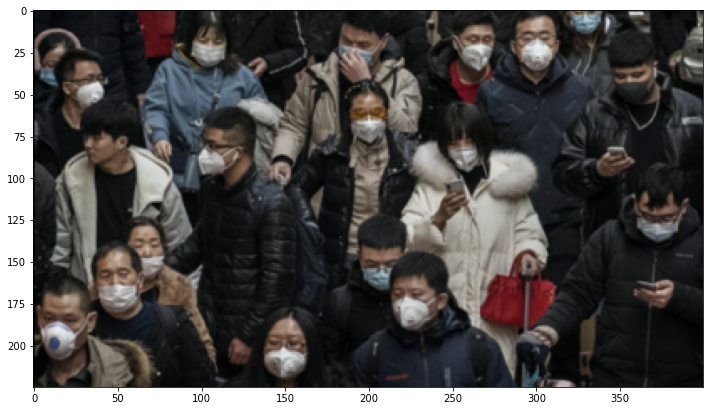

In [23]:
Desply_image()

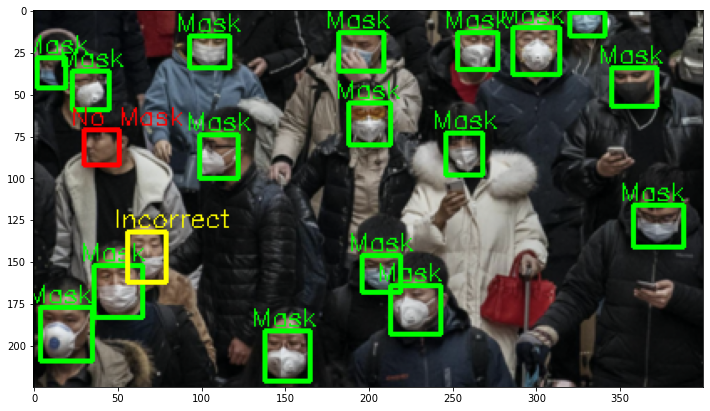

In [24]:
Desply_image_with_ann()

In [25]:
sorted_label_df = pd.DataFrame(annotations_info_df['label'].value_counts()).reset_index()
sorted_label_df.rename(columns = {'index': 'label', 'label': 'count'}, inplace = True)
sorted_label_df


label  count
0              with_mask   3232
1           without_mask    717
2  mask_weared_incorrect    123

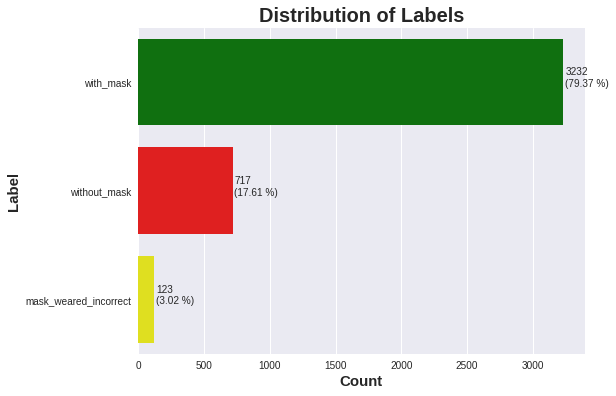

In [26]:
plt.style.use('seaborn')
plt.figure(figsize = (8, 6))
barplot = sns.barplot(x = 'count', y = 'label', data = sorted_label_df, orient = 'horizontal', 
                      palette = ['green', 'red', 'yellow'])
plt.title('Distribution of Labels', fontsize = 20, fontweight = 'bold')
plt.xlabel('Count', fontsize = 15, fontweight = 'bold')
plt.ylabel('Label', fontsize = 15, fontweight = 'bold')

for p in barplot.patches:
    width = p.get_width()
    percentage = round(width * 100 / sum(sorted_label_df['count']), 2)
    plt.text(x = width + 15, y = p.get_y() + 0.55 * p.get_height(), s = f'{int(width)}\n({percentage} %)')

plt.show()

**As a result of unbalanced labels, Our model will probably predict 'with mask' label better then 'without mask' or  'mask weared incorrect'.**

### Now let's talk about the images size

In [27]:
df_without_dup = annotations_info_df.drop_duplicates(subset=['file'])

In [28]:
images_size_df = df_without_dup[['width','height']]

In [29]:
images_size_df.describe()

width      height
count  853.000000  853.000000
mean   370.589683  309.289566
std     56.224049   74.474840
min    193.000000  156.000000
25%    301.000000  254.000000
50%    400.000000  280.000000
75%    400.000000  400.000000
max    600.000000  600.000000

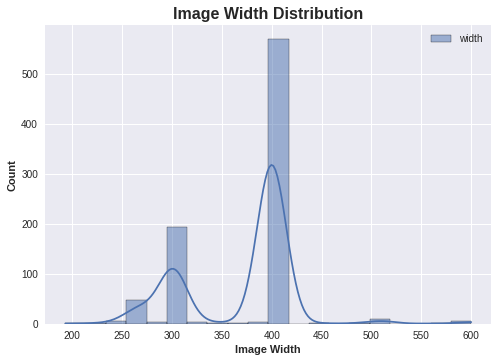

In [30]:
sns.histplot(images_size_df[['width']], kde = True)
plt.title('Image Width Distribution', fontsize = 16, fontweight = 'bold')
plt.xlabel('Image Width', fontweight = 'bold')
plt.ylabel('Count', fontweight = 'bold')
plt.show()

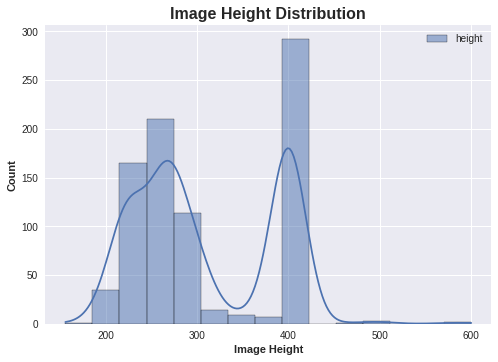

In [31]:
sns.histplot(images_size_df[['height']], kde = True)
plt.title('Image Height Distribution', fontsize = 16, fontweight = 'bold')
plt.xlabel('Image Height', fontweight = 'bold')
plt.ylabel('Count', fontweight = 'bold')
plt.show()

* **As we can see there are differences in image sizes.**
* **In our opinion, it will not be a problem in our training phase because we will resize them to a uniform size.**

# Architecture selection
* **Our chosen architecture is Faster RCNN. This architecture provides faster training and testing time.**


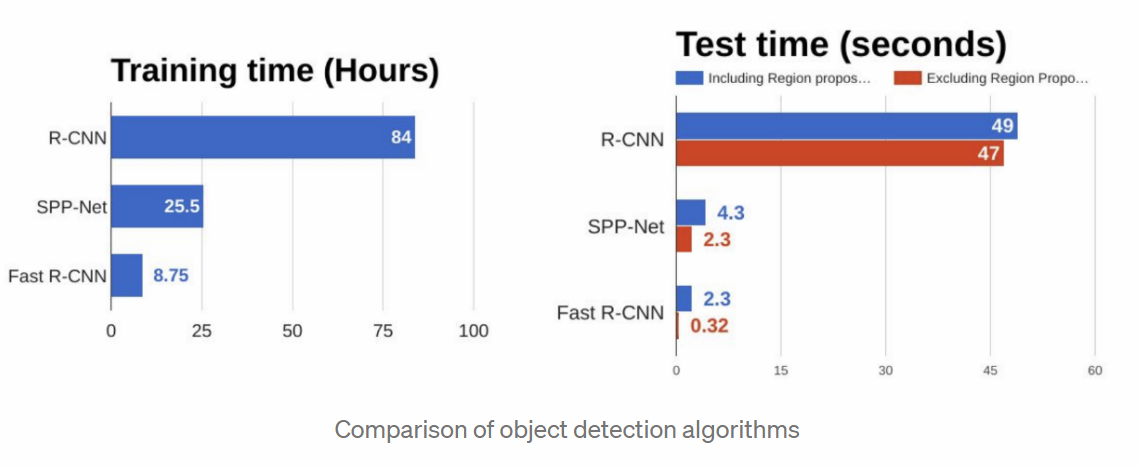

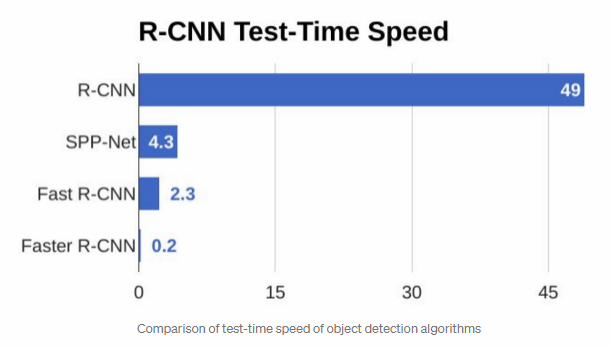

* **In Our architecture , instead of using selective search algorithm on the feature map to identify the region proposals, a separate network is used to predict the region proposals.**
* **The predicted region proposals are then reshaped using a RoI pooling layer which is then used to classify the image within the proposed region and predict the offset values for the bounding boxes.**


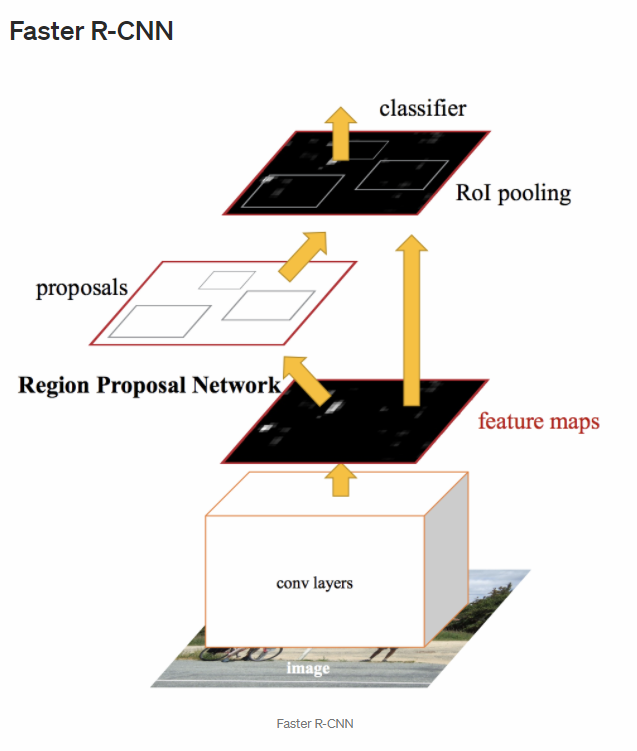

In [32]:
# https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
def get_model(num_classes, backbone = None):
    '''
    Model function to output network according to arguments.
    Args:
        num_classes: number of classes(total_classes+1 for background)
        backbone: to design network with other backbone, default backbone
                  of faster RCNN is resnet50.
    Returns:
        model.
    '''
    
    if backbone == 'mobile_net': 
        net = mobilenet_v2(pretrained = True)
        backbone_ft = net.features
        backbone_ft.out_channels = 1280
        
    elif backbone == 'vgg19':
        net = vgg19(pretrained = True)
        backbone_ft = net.features
        backbone_ft.out_channels = 512 
    
    # https://stackoverflow.com/questions/58362892/resnet-18-as-backbone-in-faster-r-cnn
    elif backbone == 'resnet101':
        net = resnet101(pretrained = True)
        modules = list(net.children())[:-1]
        backbone_ft = nn.Sequential(*modules)
        backbone_ft.out_channels = 2048
        
    if backbone is None or backbone == 'resnet50':
        
        model = fasterrcnn_resnet50_fpn(pretrained = True)
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        # print(in_features) = 1024
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        return model
    
    else:

        anchor_gen = AnchorGenerator(sizes=((32, 64, 128),))
        # featmap_names = [0] gives list index out of range error.
        roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names = ['0'],
                                                        output_size = 7,
                                                        sampling_ratio = 2)
        model = FasterRCNN(backbone_ft,
                           num_classes,
                           rpn_anchor_generator = anchor_gen,
                           box_roi_pool = roi_pooler)
        
        return model

## **Weights and biases**

In [33]:
!pip install wandb --upgrade

     |████████████████████████████████| 1.7 MB 880 kB/s 
     |████████████████████████████████| 139 kB 59.7 MB/s 
  Attempting uninstall: sentry-sdk
    Found existing installation: sentry-sdk 0.20.3
    Uninstalling sentry-sdk-0.20.3:
      Successfully uninstalled sentry-sdk-0.20.3
  Attempting uninstall: wandb
    Found existing installation: wandb 0.10.19
    Uninstalling wandb-0.10.19:
      Successfully uninstalled wandb-0.10.19
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [34]:
import wandb
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()

# I have saved my API token with "wandb_key" as Label. 
# If you use some other Label make sure to change the same below. 
wandb_key = user_secrets.get_secret("wandb_key") 

wandb.login(key=wandb_key)

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [35]:
image_ids = annotations_info_df['file'].unique() #collecting all unique images


# **Evaluation metrics**
**Intersection over Union is an evaluation metric used to measure the accuracy of an object detector on a particular dataset.**

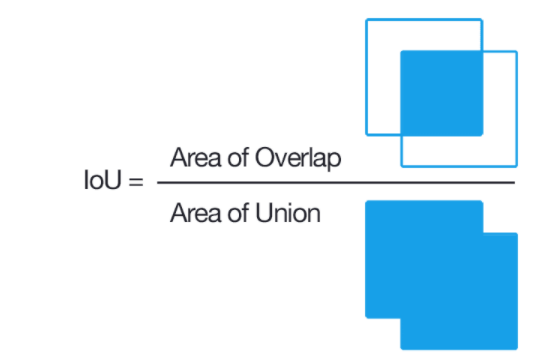

## **MAP (mean average precision) is the average of AP.**
* The general definition for the Average Precision (AP) is finding the area under the precision-recall curve
* AP is calculated for each class and averaged to get the mAP.


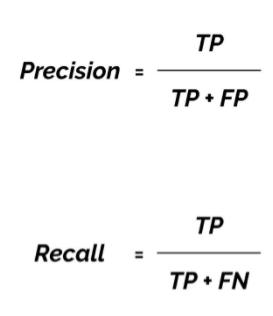


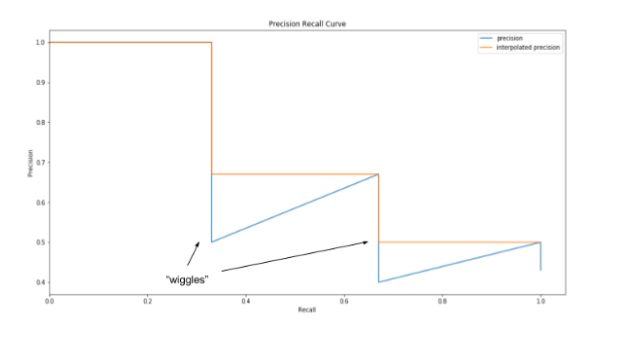

In [36]:

class AverageMeter(object):
    
    # Keeps track of most recent, average, sum, and count of a metric.
    
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [37]:

# BoilerPlate Code
iou_thresholds = numba.typed.List()

for x in [0.5, 0.55, 0.6, 0.65, 0.7, 0.75]:
    iou_thresholds.append(x)

@jit(nopython=True)
def calculate_iou(gt, pr, form='pascal_voc') -> float:
    """Calculates the Intersection over Union.

    Args:
        gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box
        pr: (np.ndarray[Union[int, float]]) coordinates of the prdected box
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )

    return overlap_area / union_area

@jit(nopython=True)
def find_best_match(gts, pred, pred_idx, threshold = 0.5, form = 'pascal_voc', ious=None) -> int:
    """Returns the index of the 'best match' between the
    ground-truth boxes and the prediction. The 'best match'
    is the highest IoU. (0.0 IoUs are ignored).

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        pred: (List[Union[int, float]]) Coordinates of the predicted box
        pred_idx: (int) Index of the current predicted box
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (int) Index of the best match GT box (-1 if no match above threshold)
    """
    best_match_iou = -np.inf
    best_match_idx = -1

    for gt_idx in range(len(gts)):
        
        if gts[gt_idx][0] < 0:
            # Already matched GT-box
            continue
        
        iou = -1 if ious is None else ious[gt_idx][pred_idx]

        if iou < 0:
            iou = calculate_iou(gts[gt_idx], pred, form=form)
            
            if ious is not None:
                ious[gt_idx][pred_idx] = iou

        if iou < threshold:
            continue

        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = gt_idx

    return best_match_idx

@jit(nopython=True)
def calculate_precision(gts, preds, threshold = 0.5, form = 'coco', ious=None) -> float:
    """Calculates precision for GT - prediction pairs at one threshold.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (float) Precision
    """
    n = len(preds)
    tp = 0
    fp = 0

    # for pred_idx, pred in enumerate(preds_sorted):
    for pred_idx in range(n):

        best_match_gt_idx = find_best_match(gts, preds[pred_idx], pred_idx,
                                            threshold=threshold, form=form, ious=ious)

        if best_match_gt_idx >= 0:
            # True positive: The predicted box matches a gt box with an IoU above the threshold.
            tp += 1
            # Remove the matched GT box
            gts[best_match_gt_idx] = -1

        else:
            # No match
            # False positive: indicates a predicted box had no associated gt box.
            fp += 1

    # False negative: indicates a gt box had no associated predicted box.
    fn = (gts.sum(axis=1) > 0).sum()

    return tp / (tp + fp + fn)

@jit(nopython=True)
def calculate_image_precision(gts, preds, thresholds = (0.5, ), form = 'coco') -> float:
    """Calculates image precision.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        thresholds: (float) Different thresholds
        form: (str) Format of the coordinates

    Return:
        (float) Precision
    """
    n_threshold = len(thresholds)
    image_precision = 0.0
    
    ious = np.ones((len(gts), len(preds))) * -1
    # ious = None

    for threshold in thresholds:
        precision_at_threshold = calculate_precision(gts.copy(), preds, threshold=threshold,
                                                     form=form, ious=ious)
        image_precision += precision_at_threshold / n_threshold

    return image_precision

def calculate_final_score(all_predictions, score_threshold,form):
    final_scores = []
    for i in range(len(all_predictions)):
        gt_boxes = all_predictions[i]['gt_boxes'].copy()
        pred_boxes = all_predictions[i]['pred_boxes'].copy()
        scores = all_predictions[i]['scores'].copy()
        image_id = all_predictions[i]['image_id']

        indexes = np.where(scores>score_threshold)
        pred_boxes = pred_boxes[indexes]
        scores = scores[indexes]

        image_precision = calculate_image_precision(gt_boxes, pred_boxes,thresholds=iou_thresholds,form=form)
        final_scores.append(image_precision)

    return np.mean(final_scores)

## Helper Functions

In [38]:
def get_image(img_dir, dataframe, idx=None, image_id=None):
    '''
    Read and output the image in the form of numpy arrays.
    Args:
        img_dir: image directory.
        dataframe: dataframe.
        idx: index to get the image with ground truth boxes before training.
        image_id: image ID, to output the image while validating.
    Returns:
        image in the form of numpy arrays.
    '''
    
    if image_id is None:
        img = os.path.join(img_dir, dataframe['image_id'][idx]) + '.jpg'
    else:
        img = os.path.join(img_dir, image_id) + '.jpg'
                           
    img = cv2.imread(img, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def show_image(img_dir, dataframe, boxes_pred=None, show=False, idx=None, image_id=None):
    '''
    Function to display the image corresponding to passed arguments.
    Args:
        img_dir: image directory.
        dataframe: dataframe.
        boxes_pred: predicted box coordinates while validation.
        show: displays the image if True.
        idx: index to get the image with ground truth boxes before training.
        image_id: image ID, to output the image while validating.
    Returns:
        if show is True then displays image with ground truth boxes before training
        if boxes_pred is None or if boxes_pred is given then displays image with ground
        truth and predicted boxes.
        if show is False then returns ground truth coordinates and predicted coordinates.
    '''

    if image_id is not None:
        image_id = image_id
    else:
        image_id = df['image_id'][idx]
    img = get_image(img_dir, dataframe, idx, image_id)
    boxes_gt = df[df['image_id'] == image_id]['bbox'].values
    for box in boxes_gt:
        box = ast.literal_eval(box) # https://stackoverflow.com/questions/29552950/when-to-use-ast-literal-eval/29556591
        x, y, w, h = int(box[0]), int(box[1]), int(box[2]), int(box[3])
        w = x + w  #x_max = w
        h = y + h  #y_max = h
        gt_rect = cv2.rectangle(img, (x,y), (w, h), (0,255,0), 3)

    if boxes_pred is not None:
        for box in boxes_pred:
            x, y, w, h = int(box[0]), int(box[1]), int(box[2]), int(box[3])
            # w = x + w  #x_max = w
            # h = y + h  #y_max = h
            pred_rect = cv2.rectangle(img, (x,y), (w, h), (255,0,0), 2)

    if show:
        if boxes_pred is None:
            plt.figure(figsize=(8,8))
            plt.axis('off')
            plt.title('Image ID: '+image_id, fontdict={'color':'cyan'})
            plt.imshow(gt_rect)
            plt.show()

        else:
            plt.figure(figsize=(8,8))
            plt.axis('off')
            plt.title('Image ID: '+image_id+'       Green: Ground Truth, Box Count: '+str(len(boxes_gt))
            +'     Red: Predicted, Box Count: '+str(len(boxes_pred)), fontdict={'color':'cyan'})
            plt.imshow(pred_rect)
            plt.show()

    else:
        if boxes_pred is None:
            return gt_pred
        else:
            return gt_rect, pred_rect

def val_show(gts, dataframe, boxes, image_id):
    '''
    Function to select predicted boxes above threshold and passing that
    as an argument to show_image function.
    Args:
        gts: ground truth box coordinates.
        dataframe: dataframe
        boxes: predicted boxes
        image_id: corresponding image ID.
    Returns:
        arguments for show_image function.
    '''

    ious = np.ones((len(gts), len(boxes))) * -1
    boxes_pred_itr = [] # for all boxes(repetition of boxes)
    boxes_pred = [] # for unique boxes
    for pred_idx in range(len(boxes)):
        best_match_gt_idx = find_best_match(gts, boxes[pred_idx], pred_idx, threshold=0.5, ious=ious)
        boxes_pred_itr.append(boxes[best_match_gt_idx])
    
    # for removing duplicate boxes
    boxes_pred = list(set(tuple(box) for box in boxes_pred_itr))
    show_image(train_dir, dataframe, boxes_pred, show=True, image_id=image_id)

# **Data Loader**

In [39]:
import os
import torch
import torch.utils.data
import torchvision
from PIL import Image
from pycocotools.coco import COCO

class myOwnDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]['file_name']
        # open the input image
        img = Image.open(os.path.join(self.root, path)).convert('RGB')

        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        labels = []
        for i in range(num_objs):
            current_ann = coco_annotation[i]
            xmin = current_ann['bbox'][0]
            ymin = current_ann['bbox'][1]
            xmax = xmin + current_ann['bbox'][2]
            ymax = ymin +current_ann['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append((current_ann['category_id'] - 1))

        labels_ = torch.as_tensor(labels, dtype = torch.int64)
        boxes = torch.as_tensor(boxes, dtype = torch.int64)
        #label = torch.IntTensor(current_ann['category_id'])
        
        # Labels (In my case, I only one class: target class or background)
        
        #img_id = torch.tensor([img_id])

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels_
        my_annotation['iscrowd'] = torch.zeros((len(boxes,)), dtype = torch.int64)
        my_annotation['area'] = torch.as_tensor(((boxes[:,3] - boxes[:,1]) * (boxes[:,2] - boxes[:,0])), dtype = torch.float32)
        my_annotation['image_id'] = torch.tensor([index])
        if self.transforms is not None:
            img = self.transforms(img)
        #print(img, my_annotation,img_id)
        return img, my_annotation,img_id

    def __len__(self):
        if DEBUG:
            return 10
        return len(self.ids)

# **Training and Validation loop Function**

In [40]:
import wandb
BATCH_SIZE = 8
ITER_STEP = 20
if DEBUG:
    EPOCHS = 5
else:
    EPOCHS = 100 # 10 / 50 / 100
model_path = None
INIT_EPOCH = None
lr = 0.01 # 0.01 ,0.001 , 0.0001 , 0.002 , 0.0003, 
opt = 'SGD' # "Adam" # 
DEVICE = torch.device('cuda') #torch.device('cpu')
models_name = ['mobile_net','vgg19','resnet101','resnet50'] 
model_name = models_name[3]
wandb.init(project="Face mask detection",name=f"{EPOCHS} epochs rcnn {model_name} - {opt} lr: {lr}")

    

wandb: Currently logged in as: liortoledano (use `wandb login --relogin` to force relogin)


In [41]:
def train_fn(dataloader, epoch, model, optimizer, device):
    '''
    Training function.
    Args:
        dataloader: for loading training data batch-wise.
        model: network architecture for training.
        optimizer: optimizer used for gradient descent.
        device: computation device for training.
    Returns:
        loss after every epoch.
    '''
    
    model.train()  # training mode enables dropout
    
    loss = AverageMeter()  # loss update/reset
    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
    
    start = time.time()
    
    loader = tqdm(dataloader, total = len(dataloader))
    for step, (images, targets, image_id) in enumerate(loader):
        
        # take the list of images and targets to feed the network
        images = [image.to(device, dtype=torch.float32) for image in images]
        targets = [{k: v.to(device) for k,v in target.items()} for target in targets]
        #print(targets)
        data_time.update(time.time() - start)
  
        # forward + backward + optimize
        loss_dict = model(images, targets)
        # loss_dict: {'loss_classifier': tensor(0.6591, device='cuda:0', grad_fn=<NllLossBackward>),
                    # 'loss_box_reg': tensor(0.7574, device='cuda:0', grad_fn=<DivBackward0>),
                    # 'loss_objectness': tensor(0.6313, device='cuda:0',
                    #                           grad_fn=<BinaryCrossEntropyWithLogitsBackward>),
                    #  'loss_rpn_box_reg': tensor(0.1344, device='cuda:0', grad_fn=<DivBackward0>)}
        losses = sum(loss_ind for loss_ind in loss_dict.values())
        
        optimizer.zero_grad()  # zero the parameter gradients
        losses.backward()
        optimizer.step()
        
        batch_time.update(time.time() - start)
        # Update loss of after every batch.
        loss.update(losses.item(), BATCH_SIZE)
        start = time.time()
        
        if step % ITER_STEP == 0:
            for key , value in loss_dict.items():
                wandb.log({'epoch': epoch+1, key: value})
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data Time {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss: {loss.val:.4f} ({loss.avg:.4f})\t'.format(epoch, step, len(dataloader),
                                                                  batch_time=batch_time,
                                                                  data_time=data_time, loss=loss))
        # To check the loss real-time while iterating.
        loader.set_postfix(loss=loss.avg)

    return loss
def val_fn(dataloader, model, device, display_random=False, show_img_num=None):
    '''
    Validation function with epoch wise visualization.
    Args:
        dataloader: to load the data batch-wise.
        model: trained model for validation.
        device: device used for computation.
        display_random: for visualiztion of random images in every epoch.
        show_img_num: to visualize a particular image, number between 0 and
                      batch size.
    Returns:
        Visualizations and a list of dictionary consisting of predicted box
        coordinates, corresponding scores, ground truth box coordinates and
        image ID.
    '''
    model.eval()
    predictions = []
    
    with torch.no_grad():
        
        loader = tqdm(dataloader, total=len(dataloader))
        for step, (images, targets, image_id) in enumerate(loader):
            
            images = [image.to(device, dtype=torch.float32) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            output = model(images)

            for i in range(len(images)):
                # tensor.detach() creates a tensor that shares storage with tensor
                # that does not require grad. It detaches the output from the computational
                # graph. So no gradient will be backpropagated along this variable.
                boxes = output[i]['boxes'].detach().cpu().numpy()
                scores = output[i]['scores'].detach().cpu().numpy()

                # boxes_itr = boxes
                predictions.append({
                    'pred_boxes': (boxes).astype(int),
                    'scores': scores,
                    'gt_boxes': (targets[i]['boxes'].cpu().numpy()).astype(int),
                    'image_id': image_id[i],
                })
                
                if display_random:
                    itr = np.random.randint(low=0, high=BATCH_SIZE-1, size=1)
                else:
                    itr = show_img_num
                
                if step%15==0 and i==itr:
                    
                    gts = (targets[i]['boxes'].cpu().numpy()).astype(int)
                    
                    #val_show(gts, df_val, boxes, image_id[i])
                
                
    return predictions

In [42]:
# collate_fn is called with a list of data samples at each time.
# It is expected to collate the input samples into a batch for
# yielding from the data loader iterator.
# https://discuss.pytorch.org/t/how-to-use-collate-fn/27181
def collate_fn(batch):
    return tuple(zip(*batch))

In [43]:
data_dir = '../input/face-mask-detection/images'
train_coco = './train.json'
val_coco = './val.json'
model_names = ['']
def engine(device, model_path=None, init_epoch=None, resume=False):
    '''
    Main funtion to train and validate.
    Args:
        device: device for computation.
        model_path: path of saved model.
        init_epoch: initial epoch to resume training from.
        resume: to resume training from last epoch.
    Return:
        final_score
    '''
    
    final_score = []
    best_score = 0
    # path to your own data and coco file

    # create own Dataset
    train_dataset = myOwnDataset(root=data_dir,
                              annotation=train_coco,
                              transforms=get_transform()
                              )

    val_dataset = myOwnDataset(root=data_dir,
                              annotation=val_coco,
                              transforms=get_transform()
                              )

    # collate_fn needs for batch
    def collate_fn(batch):
        return tuple(zip(*batch))

    # Batch size
    train_batch_size = 4
    val_batch_size = 2

    # own DataLoader
    train_data_loader = torch.utils.data.DataLoader(train_dataset,
                                              batch_size=train_batch_size,
                                              shuffle=True,
                                              num_workers=4,
                                              collate_fn=collate_fn)

    val_data_loader = torch.utils.data.DataLoader(val_dataset,
                                              batch_size=val_batch_size,
                                              shuffle=False,
                                              num_workers=4,
                                              collate_fn=collate_fn)
    
    if resume:
        model = torch.load(model_path)
        init_epoch = init_epoch
    else:
        model = get_model(4,model_name)
        #model = get_model(4)
        init_epoch = 0
    model.to(device)  # loading model on GPU

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(params, lr=lr) # lr = 0.0003 , 0.001,0.01
    if opt == 'SGD':
        optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=0.0007) # lr = 0.002, 0.01,0.1
        
    for epoch in range(init_epoch, EPOCHS):
        '''
        Call the train function then validation function to take a look on how
        model is performed in that epoch. Output of val_fn, prediction will be
        given to evaluation metrics for getting score.
        '''
        train_loss = train_fn(train_data_loader, epoch, model, optimizer, device)
        prediction = val_fn(val_data_loader, model, device, display_random=True)
        valid_score = calculate_final_score(prediction, 0.5, 'pascal_voc')
        
        
        if valid_score > best_score:
                best_score = valid_score
                torch.save(model.state_dict(), f'frcnn_best_{epoch}.pth')
#                 torch.save(model, f'frcnn_best_model_epoch_{epoch}') 
        final_score.append([valid_score, epoch])
        wandb.log({'epoch - validation': epoch+1, "MAP 0.5 - validation": valid_score})
        
    return final_score

In [44]:
%%time
final_score = engine(DEVICE)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [0][0/167]	Batch Time 1.828 (1.828)	Data Time 0.514 (0.514)	Loss: 1.8199 (1.8199)	
Epoch: [0][20/167]	Batch Time 0.445 (0.511)	Data Time 0.027 (0.044)	Loss: 0.2620 (0.8457)	
Epoch: [0][40/167]	Batch Time 0.445 (0.481)	Data Time 0.020 (0.032)	Loss: 0.3817 (0.7014)	
Epoch: [0][60/167]	Batch Time 0.476 (0.472)	Data Time 0.021 (0.029)	Loss: 0.3533 (0.6065)	
Epoch: [0][80/167]	Batch Time 0.477 (0.468)	Data Time 0.022 (0.027)	Loss: 0.2927 (0.5598)	
Epoch: [0][100/167]	Batch Time 0.478 (0.468)	Data Time 0.022 (0.026)	Loss: 0.4009 (0.5182)	
Epoch: [0][120/167]	Batch Time 0.475 (0.466)	Data Time 0.021 (0.025)	Loss: 0.3656 (0.4863)	
Epoch: [0][140/167]	Batch Time 0.497 (0.466)	Data Time 0.021 (0.024)	Loss: 0.3453 (0.4664)	
Epoch: [0][160/167]	Batch Time 0.472 (0.464)	Data Time 0.020 (0.024)	Loss: 0.1979 (0.4438)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [1][0/167]	Batch Time 0.874 (0.874)	Data Time 0.376 (0.376)	Loss: 0.2850 (0.2850)	
Epoch: [1][20/167]	Batch Time 0.527 (0.487)	Data Time 0.021 (0.042)	Loss: 0.2916 (0.3094)	
Epoch: [1][40/167]	Batch Time 0.386 (0.466)	Data Time 0.020 (0.032)	Loss: 0.4568 (0.3035)	
Epoch: [1][60/167]	Batch Time 0.475 (0.466)	Data Time 0.021 (0.029)	Loss: 0.1314 (0.2916)	
Epoch: [1][80/167]	Batch Time 0.474 (0.467)	Data Time 0.020 (0.027)	Loss: 0.3433 (0.2812)	
Epoch: [1][100/167]	Batch Time 0.395 (0.465)	Data Time 0.021 (0.026)	Loss: 0.1814 (0.2790)	
Epoch: [1][120/167]	Batch Time 0.515 (0.467)	Data Time 0.022 (0.026)	Loss: 0.1429 (0.2761)	
Epoch: [1][140/167]	Batch Time 0.388 (0.465)	Data Time 0.021 (0.025)	Loss: 0.3453 (0.2791)	
Epoch: [1][160/167]	Batch Time 0.439 (0.463)	Data Time 0.020 (0.025)	Loss: 0.0643 (0.2756)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [2][0/167]	Batch Time 0.843 (0.843)	Data Time 0.348 (0.348)	Loss: 0.3418 (0.3418)	
Epoch: [2][20/167]	Batch Time 0.474 (0.477)	Data Time 0.021 (0.038)	Loss: 0.1279 (0.2494)	
Epoch: [2][40/167]	Batch Time 0.417 (0.470)	Data Time 0.021 (0.030)	Loss: 0.1210 (0.2479)	
Epoch: [2][60/167]	Batch Time 0.373 (0.465)	Data Time 0.020 (0.028)	Loss: 0.2653 (0.2253)	
Epoch: [2][80/167]	Batch Time 0.460 (0.459)	Data Time 0.022 (0.027)	Loss: 0.3408 (0.2261)	
Epoch: [2][100/167]	Batch Time 0.480 (0.462)	Data Time 0.020 (0.026)	Loss: 0.3158 (0.2331)	
Epoch: [2][120/167]	Batch Time 0.477 (0.460)	Data Time 0.021 (0.025)	Loss: 0.1875 (0.2380)	
Epoch: [2][140/167]	Batch Time 0.493 (0.462)	Data Time 0.021 (0.025)	Loss: 0.2512 (0.2379)	
Epoch: [2][160/167]	Batch Time 0.517 (0.459)	Data Time 0.020 (0.024)	Loss: 0.0966 (0.2376)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [3][0/167]	Batch Time 1.075 (1.075)	Data Time 0.583 (0.583)	Loss: 0.2258 (0.2258)	
Epoch: [3][20/167]	Batch Time 0.439 (0.482)	Data Time 0.022 (0.049)	Loss: 0.0560 (0.1994)	
Epoch: [3][40/167]	Batch Time 0.394 (0.475)	Data Time 0.022 (0.038)	Loss: 0.1892 (0.2087)	
Epoch: [3][60/167]	Batch Time 0.385 (0.468)	Data Time 0.021 (0.033)	Loss: 0.3191 (0.2167)	
Epoch: [3][80/167]	Batch Time 0.467 (0.467)	Data Time 0.022 (0.031)	Loss: 0.2267 (0.2134)	
Epoch: [3][100/167]	Batch Time 0.382 (0.463)	Data Time 0.019 (0.029)	Loss: 0.3471 (0.2136)	
Epoch: [3][120/167]	Batch Time 0.515 (0.463)	Data Time 0.021 (0.028)	Loss: 0.1486 (0.2106)	
Epoch: [3][140/167]	Batch Time 0.438 (0.461)	Data Time 0.021 (0.027)	Loss: 0.2349 (0.2098)	
Epoch: [3][160/167]	Batch Time 0.471 (0.460)	Data Time 0.019 (0.026)	Loss: 0.0870 (0.2059)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [4][0/167]	Batch Time 0.859 (0.859)	Data Time 0.379 (0.379)	Loss: 0.2022 (0.2022)	
Epoch: [4][20/167]	Batch Time 0.392 (0.468)	Data Time 0.022 (0.039)	Loss: 0.2465 (0.1685)	
Epoch: [4][40/167]	Batch Time 0.473 (0.457)	Data Time 0.021 (0.032)	Loss: 0.1746 (0.1790)	
Epoch: [4][60/167]	Batch Time 0.508 (0.462)	Data Time 0.021 (0.028)	Loss: 0.2250 (0.1693)	
Epoch: [4][80/167]	Batch Time 0.387 (0.463)	Data Time 0.022 (0.027)	Loss: 0.3091 (0.1705)	
Epoch: [4][100/167]	Batch Time 0.426 (0.457)	Data Time 0.043 (0.026)	Loss: 0.2279 (0.1762)	
Epoch: [4][120/167]	Batch Time 0.387 (0.457)	Data Time 0.021 (0.026)	Loss: 0.3366 (0.1792)	
Epoch: [4][140/167]	Batch Time 0.534 (0.456)	Data Time 0.036 (0.025)	Loss: 0.2890 (0.1794)	
Epoch: [4][160/167]	Batch Time 0.476 (0.457)	Data Time 0.021 (0.025)	Loss: 0.2111 (0.1793)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [5][0/167]	Batch Time 0.944 (0.944)	Data Time 0.481 (0.481)	Loss: 0.1440 (0.1440)	
Epoch: [5][20/167]	Batch Time 0.479 (0.478)	Data Time 0.021 (0.042)	Loss: 0.3200 (0.1511)	
Epoch: [5][40/167]	Batch Time 0.476 (0.477)	Data Time 0.021 (0.034)	Loss: 0.1855 (0.1422)	
Epoch: [5][60/167]	Batch Time 0.387 (0.468)	Data Time 0.022 (0.030)	Loss: 0.1879 (0.1463)	
Epoch: [5][80/167]	Batch Time 0.473 (0.467)	Data Time 0.020 (0.028)	Loss: 0.0889 (0.1523)	
Epoch: [5][100/167]	Batch Time 0.517 (0.465)	Data Time 0.021 (0.027)	Loss: 0.1643 (0.1582)	
Epoch: [5][120/167]	Batch Time 0.457 (0.463)	Data Time 0.022 (0.026)	Loss: 0.1211 (0.1630)	
Epoch: [5][140/167]	Batch Time 0.385 (0.463)	Data Time 0.021 (0.026)	Loss: 0.2297 (0.1628)	
Epoch: [5][160/167]	Batch Time 0.455 (0.461)	Data Time 0.021 (0.025)	Loss: 0.1058 (0.1642)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [6][0/167]	Batch Time 0.866 (0.866)	Data Time 0.258 (0.258)	Loss: 0.1293 (0.1293)	
Epoch: [6][20/167]	Batch Time 0.484 (0.464)	Data Time 0.027 (0.033)	Loss: 0.1183 (0.1399)	
Epoch: [6][40/167]	Batch Time 0.439 (0.465)	Data Time 0.021 (0.028)	Loss: 0.0750 (0.1492)	
Epoch: [6][60/167]	Batch Time 0.469 (0.461)	Data Time 0.019 (0.026)	Loss: 0.0725 (0.1506)	
Epoch: [6][80/167]	Batch Time 0.477 (0.463)	Data Time 0.022 (0.025)	Loss: 0.2092 (0.1458)	
Epoch: [6][100/167]	Batch Time 0.517 (0.465)	Data Time 0.022 (0.024)	Loss: 0.2030 (0.1525)	
Epoch: [6][120/167]	Batch Time 0.440 (0.464)	Data Time 0.021 (0.024)	Loss: 0.0943 (0.1488)	
Epoch: [6][140/167]	Batch Time 0.478 (0.463)	Data Time 0.021 (0.024)	Loss: 0.1782 (0.1531)	
Epoch: [6][160/167]	Batch Time 0.515 (0.460)	Data Time 0.020 (0.024)	Loss: 0.1850 (0.1526)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [7][0/167]	Batch Time 0.871 (0.871)	Data Time 0.392 (0.392)	Loss: 0.1569 (0.1569)	
Epoch: [7][20/167]	Batch Time 0.438 (0.481)	Data Time 0.022 (0.042)	Loss: 0.0460 (0.1372)	
Epoch: [7][40/167]	Batch Time 0.549 (0.471)	Data Time 0.020 (0.033)	Loss: 0.2742 (0.1367)	
Epoch: [7][60/167]	Batch Time 0.492 (0.467)	Data Time 0.037 (0.030)	Loss: 0.1321 (0.1419)	
Epoch: [7][80/167]	Batch Time 0.492 (0.459)	Data Time 0.021 (0.028)	Loss: 0.1289 (0.1443)	
Epoch: [7][100/167]	Batch Time 0.486 (0.462)	Data Time 0.023 (0.027)	Loss: 0.0721 (0.1402)	
Epoch: [7][120/167]	Batch Time 0.519 (0.464)	Data Time 0.021 (0.026)	Loss: 0.1069 (0.1404)	
Epoch: [7][140/167]	Batch Time 0.438 (0.465)	Data Time 0.022 (0.026)	Loss: 0.0371 (0.1394)	
Epoch: [7][160/167]	Batch Time 0.385 (0.462)	Data Time 0.021 (0.025)	Loss: 0.1950 (0.1405)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [8][0/167]	Batch Time 0.800 (0.800)	Data Time 0.309 (0.309)	Loss: 0.0997 (0.0997)	
Epoch: [8][20/167]	Batch Time 0.539 (0.473)	Data Time 0.021 (0.039)	Loss: 0.2088 (0.1377)	
Epoch: [8][40/167]	Batch Time 0.473 (0.465)	Data Time 0.020 (0.030)	Loss: 0.1026 (0.1286)	
Epoch: [8][60/167]	Batch Time 0.387 (0.460)	Data Time 0.020 (0.028)	Loss: 0.2176 (0.1289)	
Epoch: [8][80/167]	Batch Time 0.387 (0.455)	Data Time 0.020 (0.027)	Loss: 0.2003 (0.1292)	
Epoch: [8][100/167]	Batch Time 0.472 (0.456)	Data Time 0.020 (0.026)	Loss: 0.1348 (0.1301)	
Epoch: [8][120/167]	Batch Time 0.462 (0.456)	Data Time 0.020 (0.025)	Loss: 0.1514 (0.1322)	
Epoch: [8][140/167]	Batch Time 0.459 (0.458)	Data Time 0.021 (0.025)	Loss: 0.1378 (0.1286)	
Epoch: [8][160/167]	Batch Time 0.422 (0.456)	Data Time 0.022 (0.024)	Loss: 0.0418 (0.1237)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [9][0/167]	Batch Time 0.874 (0.874)	Data Time 0.483 (0.483)	Loss: 0.1988 (0.1988)	
Epoch: [9][20/167]	Batch Time 0.537 (0.470)	Data Time 0.019 (0.041)	Loss: 0.2697 (0.1438)	
Epoch: [9][40/167]	Batch Time 0.445 (0.461)	Data Time 0.026 (0.032)	Loss: 0.1589 (0.1381)	
Epoch: [9][60/167]	Batch Time 0.473 (0.461)	Data Time 0.020 (0.028)	Loss: 0.1610 (0.1315)	
Epoch: [9][80/167]	Batch Time 0.364 (0.461)	Data Time 0.022 (0.027)	Loss: 0.0628 (0.1307)	
Epoch: [9][100/167]	Batch Time 0.387 (0.457)	Data Time 0.021 (0.026)	Loss: 0.0882 (0.1253)	
Epoch: [9][120/167]	Batch Time 0.513 (0.458)	Data Time 0.021 (0.025)	Loss: 0.0975 (0.1248)	
Epoch: [9][140/167]	Batch Time 0.407 (0.456)	Data Time 0.020 (0.025)	Loss: 0.0484 (0.1219)	
Epoch: [9][160/167]	Batch Time 0.408 (0.456)	Data Time 0.021 (0.025)	Loss: 0.0578 (0.1223)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [10][0/167]	Batch Time 0.852 (0.852)	Data Time 0.374 (0.374)	Loss: 0.1941 (0.1941)	
Epoch: [10][20/167]	Batch Time 0.515 (0.467)	Data Time 0.020 (0.038)	Loss: 0.0606 (0.1188)	
Epoch: [10][40/167]	Batch Time 0.460 (0.460)	Data Time 0.021 (0.031)	Loss: 0.0473 (0.1158)	
Epoch: [10][60/167]	Batch Time 0.513 (0.460)	Data Time 0.020 (0.028)	Loss: 0.1431 (0.1190)	
Epoch: [10][80/167]	Batch Time 0.472 (0.459)	Data Time 0.021 (0.026)	Loss: 0.0774 (0.1182)	
Epoch: [10][100/167]	Batch Time 0.512 (0.458)	Data Time 0.036 (0.025)	Loss: 0.1210 (0.1168)	
Epoch: [10][120/167]	Batch Time 0.471 (0.461)	Data Time 0.021 (0.027)	Loss: 0.0985 (0.1184)	
Epoch: [10][140/167]	Batch Time 0.442 (0.462)	Data Time 0.021 (0.026)	Loss: 0.1013 (0.1166)	
Epoch: [10][160/167]	Batch Time 0.415 (0.459)	Data Time 0.019 (0.026)	Loss: 0.0379 (0.1166)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [11][0/167]	Batch Time 0.861 (0.861)	Data Time 0.418 (0.418)	Loss: 0.1693 (0.1693)	
Epoch: [11][20/167]	Batch Time 0.477 (0.482)	Data Time 0.024 (0.040)	Loss: 0.0792 (0.1074)	
Epoch: [11][40/167]	Batch Time 0.538 (0.466)	Data Time 0.040 (0.032)	Loss: 0.1021 (0.1033)	
Epoch: [11][60/167]	Batch Time 0.464 (0.462)	Data Time 0.020 (0.028)	Loss: 0.0954 (0.1024)	
Epoch: [11][80/167]	Batch Time 0.476 (0.462)	Data Time 0.024 (0.027)	Loss: 0.0782 (0.1005)	
Epoch: [11][100/167]	Batch Time 0.516 (0.461)	Data Time 0.021 (0.026)	Loss: 0.0607 (0.1012)	
Epoch: [11][120/167]	Batch Time 0.478 (0.460)	Data Time 0.021 (0.025)	Loss: 0.0462 (0.1027)	
Epoch: [11][140/167]	Batch Time 0.441 (0.460)	Data Time 0.021 (0.025)	Loss: 0.1915 (0.1027)	
Epoch: [11][160/167]	Batch Time 0.534 (0.460)	Data Time 0.021 (0.024)	Loss: 0.1160 (0.1008)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [12][0/167]	Batch Time 1.047 (1.047)	Data Time 0.562 (0.562)	Loss: 0.1100 (0.1100)	
Epoch: [12][20/167]	Batch Time 0.477 (0.481)	Data Time 0.022 (0.047)	Loss: 0.1718 (0.0957)	
Epoch: [12][40/167]	Batch Time 0.484 (0.474)	Data Time 0.023 (0.035)	Loss: 0.1264 (0.0950)	
Epoch: [12][60/167]	Batch Time 0.437 (0.460)	Data Time 0.021 (0.031)	Loss: 0.0730 (0.1014)	
Epoch: [12][80/167]	Batch Time 0.387 (0.458)	Data Time 0.021 (0.028)	Loss: 0.2369 (0.1010)	
Epoch: [12][100/167]	Batch Time 0.474 (0.460)	Data Time 0.023 (0.027)	Loss: 0.0635 (0.1017)	
Epoch: [12][120/167]	Batch Time 0.474 (0.458)	Data Time 0.022 (0.027)	Loss: 0.0802 (0.1014)	
Epoch: [12][140/167]	Batch Time 0.441 (0.457)	Data Time 0.022 (0.026)	Loss: 0.1005 (0.1015)	
Epoch: [12][160/167]	Batch Time 0.474 (0.458)	Data Time 0.020 (0.026)	Loss: 0.0536 (0.0987)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [13][0/167]	Batch Time 0.899 (0.899)	Data Time 0.412 (0.412)	Loss: 0.0991 (0.0991)	
Epoch: [13][20/167]	Batch Time 0.474 (0.465)	Data Time 0.023 (0.041)	Loss: 0.0786 (0.0997)	
Epoch: [13][40/167]	Batch Time 0.477 (0.463)	Data Time 0.021 (0.032)	Loss: 0.1290 (0.0947)	
Epoch: [13][60/167]	Batch Time 0.388 (0.457)	Data Time 0.022 (0.029)	Loss: 0.0912 (0.0961)	
Epoch: [13][80/167]	Batch Time 0.440 (0.460)	Data Time 0.021 (0.027)	Loss: 0.0968 (0.0937)	
Epoch: [13][100/167]	Batch Time 0.490 (0.460)	Data Time 0.022 (0.026)	Loss: 0.0894 (0.0938)	
Epoch: [13][120/167]	Batch Time 0.518 (0.461)	Data Time 0.022 (0.025)	Loss: 0.1025 (0.0933)	
Epoch: [13][140/167]	Batch Time 0.473 (0.461)	Data Time 0.022 (0.025)	Loss: 0.1001 (0.0919)	
Epoch: [13][160/167]	Batch Time 0.515 (0.461)	Data Time 0.020 (0.025)	Loss: 0.0706 (0.0936)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [14][0/167]	Batch Time 0.762 (0.762)	Data Time 0.358 (0.358)	Loss: 0.0457 (0.0457)	
Epoch: [14][20/167]	Batch Time 0.481 (0.486)	Data Time 0.029 (0.039)	Loss: 0.0901 (0.0924)	
Epoch: [14][40/167]	Batch Time 0.405 (0.469)	Data Time 0.021 (0.030)	Loss: 0.0894 (0.0910)	
Epoch: [14][60/167]	Batch Time 0.515 (0.472)	Data Time 0.021 (0.028)	Loss: 0.0905 (0.0879)	
Epoch: [14][80/167]	Batch Time 0.506 (0.467)	Data Time 0.021 (0.027)	Loss: 0.0672 (0.0869)	
Epoch: [14][100/167]	Batch Time 0.477 (0.464)	Data Time 0.022 (0.026)	Loss: 0.0302 (0.0907)	
Epoch: [14][120/167]	Batch Time 0.475 (0.459)	Data Time 0.021 (0.026)	Loss: 0.0352 (0.0904)	
Epoch: [14][140/167]	Batch Time 0.387 (0.460)	Data Time 0.021 (0.026)	Loss: 0.1103 (0.0911)	
Epoch: [14][160/167]	Batch Time 0.388 (0.460)	Data Time 0.021 (0.025)	Loss: 0.1869 (0.0919)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [15][0/167]	Batch Time 0.967 (0.967)	Data Time 0.495 (0.495)	Loss: 0.1096 (0.1096)	
Epoch: [15][20/167]	Batch Time 0.438 (0.485)	Data Time 0.020 (0.045)	Loss: 0.0540 (0.0928)	
Epoch: [15][40/167]	Batch Time 0.475 (0.472)	Data Time 0.020 (0.035)	Loss: 0.0328 (0.1066)	
Epoch: [15][60/167]	Batch Time 0.474 (0.467)	Data Time 0.021 (0.031)	Loss: 0.1200 (0.1080)	
Epoch: [15][80/167]	Batch Time 0.474 (0.469)	Data Time 0.022 (0.029)	Loss: 0.0521 (0.1057)	
Epoch: [15][100/167]	Batch Time 0.510 (0.471)	Data Time 0.021 (0.028)	Loss: 0.0995 (0.1040)	
Epoch: [15][120/167]	Batch Time 0.453 (0.468)	Data Time 0.022 (0.027)	Loss: 0.0594 (0.0994)	
Epoch: [15][140/167]	Batch Time 0.517 (0.468)	Data Time 0.053 (0.027)	Loss: 0.0482 (0.0983)	
Epoch: [15][160/167]	Batch Time 0.442 (0.464)	Data Time 0.022 (0.026)	Loss: 0.0926 (0.0974)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [16][0/167]	Batch Time 0.841 (0.841)	Data Time 0.360 (0.360)	Loss: 0.0483 (0.0483)	
Epoch: [16][20/167]	Batch Time 0.476 (0.471)	Data Time 0.021 (0.038)	Loss: 0.0494 (0.0799)	
Epoch: [16][40/167]	Batch Time 0.388 (0.459)	Data Time 0.021 (0.030)	Loss: 0.0830 (0.0833)	
Epoch: [16][60/167]	Batch Time 0.477 (0.459)	Data Time 0.022 (0.028)	Loss: 0.0292 (0.0818)	
Epoch: [16][80/167]	Batch Time 0.466 (0.459)	Data Time 0.020 (0.026)	Loss: 0.0929 (0.0822)	
Epoch: [16][100/167]	Batch Time 0.384 (0.456)	Data Time 0.020 (0.025)	Loss: 0.0535 (0.0822)	
Epoch: [16][120/167]	Batch Time 0.438 (0.456)	Data Time 0.020 (0.025)	Loss: 0.0312 (0.0809)	
Epoch: [16][140/167]	Batch Time 0.514 (0.457)	Data Time 0.021 (0.024)	Loss: 0.0574 (0.0824)	
Epoch: [16][160/167]	Batch Time 0.438 (0.456)	Data Time 0.021 (0.024)	Loss: 0.0562 (0.0833)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [17][0/167]	Batch Time 1.005 (1.005)	Data Time 0.465 (0.465)	Loss: 0.0518 (0.0518)	
Epoch: [17][20/167]	Batch Time 0.387 (0.487)	Data Time 0.021 (0.045)	Loss: 0.0609 (0.0667)	
Epoch: [17][40/167]	Batch Time 0.474 (0.473)	Data Time 0.019 (0.034)	Loss: 0.0945 (0.0718)	
Epoch: [17][60/167]	Batch Time 0.390 (0.462)	Data Time 0.023 (0.031)	Loss: 0.1152 (0.0855)	
Epoch: [17][80/167]	Batch Time 0.402 (0.465)	Data Time 0.037 (0.029)	Loss: 0.1294 (0.0885)	
Epoch: [17][100/167]	Batch Time 0.387 (0.460)	Data Time 0.022 (0.027)	Loss: 0.0773 (0.0872)	
Epoch: [17][120/167]	Batch Time 0.553 (0.458)	Data Time 0.040 (0.026)	Loss: 0.0771 (0.0847)	
Epoch: [17][140/167]	Batch Time 0.385 (0.457)	Data Time 0.020 (0.026)	Loss: 0.1186 (0.0865)	
Epoch: [17][160/167]	Batch Time 0.519 (0.459)	Data Time 0.021 (0.025)	Loss: 0.0430 (0.0851)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [18][0/167]	Batch Time 0.927 (0.927)	Data Time 0.449 (0.449)	Loss: 0.0241 (0.0241)	
Epoch: [18][20/167]	Batch Time 0.420 (0.481)	Data Time 0.036 (0.041)	Loss: 0.0972 (0.0629)	
Epoch: [18][40/167]	Batch Time 0.389 (0.458)	Data Time 0.022 (0.032)	Loss: 0.1576 (0.0773)	
Epoch: [18][60/167]	Batch Time 0.513 (0.462)	Data Time 0.022 (0.029)	Loss: 0.0398 (0.0766)	
Epoch: [18][80/167]	Batch Time 0.472 (0.458)	Data Time 0.020 (0.027)	Loss: 0.0655 (0.0779)	
Epoch: [18][100/167]	Batch Time 0.493 (0.456)	Data Time 0.020 (0.026)	Loss: 0.0465 (0.0767)	
Epoch: [18][120/167]	Batch Time 0.468 (0.457)	Data Time 0.020 (0.025)	Loss: 0.0507 (0.0786)	
Epoch: [18][140/167]	Batch Time 0.495 (0.458)	Data Time 0.022 (0.025)	Loss: 0.1027 (0.0795)	
Epoch: [18][160/167]	Batch Time 0.513 (0.458)	Data Time 0.020 (0.024)	Loss: 0.0690 (0.0815)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [19][0/167]	Batch Time 0.866 (0.866)	Data Time 0.379 (0.379)	Loss: 0.0870 (0.0870)	
Epoch: [19][20/167]	Batch Time 0.478 (0.470)	Data Time 0.020 (0.037)	Loss: 0.0993 (0.1101)	
Epoch: [19][40/167]	Batch Time 0.443 (0.463)	Data Time 0.020 (0.030)	Loss: 0.0669 (0.1010)	
Epoch: [19][60/167]	Batch Time 0.477 (0.463)	Data Time 0.022 (0.027)	Loss: 0.0520 (0.0948)	
Epoch: [19][80/167]	Batch Time 0.386 (0.460)	Data Time 0.021 (0.026)	Loss: 0.0827 (0.0932)	
Epoch: [19][100/167]	Batch Time 0.461 (0.460)	Data Time 0.036 (0.025)	Loss: 0.0457 (0.0909)	
Epoch: [19][120/167]	Batch Time 0.469 (0.458)	Data Time 0.021 (0.025)	Loss: 0.1071 (0.0891)	
Epoch: [19][140/167]	Batch Time 0.477 (0.460)	Data Time 0.021 (0.024)	Loss: 0.1022 (0.0890)	
Epoch: [19][160/167]	Batch Time 0.474 (0.460)	Data Time 0.020 (0.024)	Loss: 0.0516 (0.0890)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [20][0/167]	Batch Time 0.964 (0.964)	Data Time 0.451 (0.451)	Loss: 0.0676 (0.0676)	
Epoch: [20][20/167]	Batch Time 0.513 (0.470)	Data Time 0.020 (0.042)	Loss: 0.0429 (0.0616)	
Epoch: [20][40/167]	Batch Time 0.475 (0.456)	Data Time 0.021 (0.033)	Loss: 0.0683 (0.0657)	
Epoch: [20][60/167]	Batch Time 0.450 (0.457)	Data Time 0.021 (0.029)	Loss: 0.0716 (0.0732)	
Epoch: [20][80/167]	Batch Time 0.496 (0.458)	Data Time 0.040 (0.028)	Loss: 0.0152 (0.0762)	
Epoch: [20][100/167]	Batch Time 0.416 (0.458)	Data Time 0.021 (0.027)	Loss: 0.0434 (0.0764)	
Epoch: [20][120/167]	Batch Time 0.475 (0.459)	Data Time 0.021 (0.026)	Loss: 0.0349 (0.0750)	
Epoch: [20][140/167]	Batch Time 0.457 (0.459)	Data Time 0.040 (0.026)	Loss: 0.0713 (0.0749)	
Epoch: [20][160/167]	Batch Time 0.474 (0.459)	Data Time 0.021 (0.025)	Loss: 0.0795 (0.0766)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [21][0/167]	Batch Time 0.840 (0.840)	Data Time 0.398 (0.398)	Loss: 0.0820 (0.0820)	
Epoch: [21][20/167]	Batch Time 0.361 (0.470)	Data Time 0.022 (0.039)	Loss: 0.0715 (0.0615)	
Epoch: [21][40/167]	Batch Time 0.478 (0.468)	Data Time 0.026 (0.031)	Loss: 0.0392 (0.0670)	
Epoch: [21][60/167]	Batch Time 0.467 (0.471)	Data Time 0.026 (0.028)	Loss: 0.0439 (0.0662)	
Epoch: [21][80/167]	Batch Time 0.440 (0.466)	Data Time 0.021 (0.026)	Loss: 0.0898 (0.0742)	
Epoch: [21][100/167]	Batch Time 0.552 (0.462)	Data Time 0.021 (0.025)	Loss: 0.0904 (0.0740)	
Epoch: [21][120/167]	Batch Time 0.471 (0.461)	Data Time 0.020 (0.025)	Loss: 0.0434 (0.0755)	
Epoch: [21][140/167]	Batch Time 0.517 (0.461)	Data Time 0.021 (0.024)	Loss: 0.1038 (0.0758)	
Epoch: [21][160/167]	Batch Time 0.474 (0.459)	Data Time 0.020 (0.024)	Loss: 0.0916 (0.0771)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [22][0/167]	Batch Time 0.817 (0.817)	Data Time 0.348 (0.348)	Loss: 0.0714 (0.0714)	
Epoch: [22][20/167]	Batch Time 0.475 (0.479)	Data Time 0.022 (0.038)	Loss: 0.0791 (0.0829)	
Epoch: [22][40/167]	Batch Time 0.503 (0.469)	Data Time 0.020 (0.031)	Loss: 0.0956 (0.0831)	
Epoch: [22][60/167]	Batch Time 0.478 (0.462)	Data Time 0.021 (0.028)	Loss: 0.0604 (0.0873)	
Epoch: [22][80/167]	Batch Time 0.478 (0.458)	Data Time 0.021 (0.026)	Loss: 0.1221 (0.0877)	
Epoch: [22][100/167]	Batch Time 0.386 (0.458)	Data Time 0.020 (0.025)	Loss: 0.1405 (0.0912)	
Epoch: [22][120/167]	Batch Time 0.374 (0.456)	Data Time 0.021 (0.025)	Loss: 0.0870 (0.0884)	
Epoch: [22][140/167]	Batch Time 0.474 (0.456)	Data Time 0.022 (0.024)	Loss: 0.0253 (0.0860)	
Epoch: [22][160/167]	Batch Time 0.473 (0.456)	Data Time 0.019 (0.024)	Loss: 0.0782 (0.0854)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [23][0/167]	Batch Time 0.934 (0.934)	Data Time 0.448 (0.448)	Loss: 0.0335 (0.0335)	
Epoch: [23][20/167]	Batch Time 0.393 (0.482)	Data Time 0.026 (0.042)	Loss: 0.1617 (0.0631)	
Epoch: [23][40/167]	Batch Time 0.514 (0.465)	Data Time 0.021 (0.032)	Loss: 0.0540 (0.0636)	
Epoch: [23][60/167]	Batch Time 0.491 (0.462)	Data Time 0.020 (0.030)	Loss: 0.0413 (0.0676)	
Epoch: [23][80/167]	Batch Time 0.523 (0.460)	Data Time 0.035 (0.028)	Loss: 0.1106 (0.0702)	
Epoch: [23][100/167]	Batch Time 0.475 (0.458)	Data Time 0.021 (0.027)	Loss: 0.1734 (0.0710)	
Epoch: [23][120/167]	Batch Time 0.388 (0.458)	Data Time 0.021 (0.026)	Loss: 0.1639 (0.0702)	
Epoch: [23][140/167]	Batch Time 0.367 (0.456)	Data Time 0.020 (0.025)	Loss: 0.0810 (0.0720)	
Epoch: [23][160/167]	Batch Time 0.383 (0.454)	Data Time 0.020 (0.025)	Loss: 0.0973 (0.0720)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [24][0/167]	Batch Time 0.982 (0.982)	Data Time 0.451 (0.451)	Loss: 0.0342 (0.0342)	
Epoch: [24][20/167]	Batch Time 0.477 (0.490)	Data Time 0.020 (0.043)	Loss: 0.1027 (0.0746)	
Epoch: [24][40/167]	Batch Time 0.514 (0.482)	Data Time 0.020 (0.033)	Loss: 0.0538 (0.0669)	
Epoch: [24][60/167]	Batch Time 0.472 (0.464)	Data Time 0.021 (0.029)	Loss: 0.0629 (0.0695)	
Epoch: [24][80/167]	Batch Time 0.472 (0.465)	Data Time 0.020 (0.028)	Loss: 0.0590 (0.0708)	
Epoch: [24][100/167]	Batch Time 0.360 (0.462)	Data Time 0.020 (0.026)	Loss: 0.0743 (0.0697)	
Epoch: [24][120/167]	Batch Time 0.485 (0.462)	Data Time 0.020 (0.026)	Loss: 0.0542 (0.0702)	
Epoch: [24][140/167]	Batch Time 0.387 (0.459)	Data Time 0.021 (0.025)	Loss: 0.0933 (0.0685)	
Epoch: [24][160/167]	Batch Time 0.435 (0.457)	Data Time 0.020 (0.025)	Loss: 0.0442 (0.0671)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [25][0/167]	Batch Time 0.910 (0.910)	Data Time 0.470 (0.470)	Loss: 0.0751 (0.0751)	
Epoch: [25][20/167]	Batch Time 0.389 (0.477)	Data Time 0.019 (0.041)	Loss: 0.1105 (0.0911)	
Epoch: [25][40/167]	Batch Time 0.474 (0.467)	Data Time 0.020 (0.033)	Loss: 0.0561 (0.0809)	
Epoch: [25][60/167]	Batch Time 0.502 (0.463)	Data Time 0.033 (0.029)	Loss: 0.0734 (0.0739)	
Epoch: [25][80/167]	Batch Time 0.386 (0.462)	Data Time 0.021 (0.028)	Loss: 0.1015 (0.0766)	
Epoch: [25][100/167]	Batch Time 0.470 (0.461)	Data Time 0.020 (0.026)	Loss: 0.0272 (0.0740)	
Epoch: [25][120/167]	Batch Time 0.363 (0.461)	Data Time 0.021 (0.026)	Loss: 0.0201 (0.0728)	
Epoch: [25][140/167]	Batch Time 0.384 (0.457)	Data Time 0.020 (0.025)	Loss: 0.0523 (0.0714)	
Epoch: [25][160/167]	Batch Time 0.437 (0.457)	Data Time 0.019 (0.025)	Loss: 0.0765 (0.0726)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [26][0/167]	Batch Time 0.872 (0.872)	Data Time 0.491 (0.491)	Loss: 0.0536 (0.0536)	
Epoch: [26][20/167]	Batch Time 0.438 (0.471)	Data Time 0.021 (0.043)	Loss: 0.0799 (0.0760)	
Epoch: [26][40/167]	Batch Time 0.445 (0.455)	Data Time 0.020 (0.033)	Loss: 0.0694 (0.0713)	
Epoch: [26][60/167]	Batch Time 0.385 (0.456)	Data Time 0.021 (0.029)	Loss: 0.0809 (0.0705)	
Epoch: [26][80/167]	Batch Time 0.440 (0.452)	Data Time 0.022 (0.027)	Loss: 0.0776 (0.0685)	
Epoch: [26][100/167]	Batch Time 0.471 (0.452)	Data Time 0.021 (0.026)	Loss: 0.0744 (0.0676)	
Epoch: [26][120/167]	Batch Time 0.474 (0.454)	Data Time 0.021 (0.025)	Loss: 0.0563 (0.0650)	
Epoch: [26][140/167]	Batch Time 0.391 (0.452)	Data Time 0.019 (0.025)	Loss: 0.1032 (0.0646)	
Epoch: [26][160/167]	Batch Time 0.520 (0.455)	Data Time 0.021 (0.024)	Loss: 0.0839 (0.0636)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [27][0/167]	Batch Time 0.927 (0.927)	Data Time 0.492 (0.492)	Loss: 0.0758 (0.0758)	
Epoch: [27][20/167]	Batch Time 0.531 (0.484)	Data Time 0.021 (0.043)	Loss: 0.0367 (0.0562)	
Epoch: [27][40/167]	Batch Time 0.473 (0.475)	Data Time 0.022 (0.033)	Loss: 0.0654 (0.0580)	
Epoch: [27][60/167]	Batch Time 0.439 (0.470)	Data Time 0.021 (0.029)	Loss: 0.0182 (0.0605)	
Epoch: [27][80/167]	Batch Time 0.439 (0.467)	Data Time 0.020 (0.028)	Loss: 0.0411 (0.0615)	
Epoch: [27][100/167]	Batch Time 0.516 (0.464)	Data Time 0.045 (0.027)	Loss: 0.0732 (0.0623)	
Epoch: [27][120/167]	Batch Time 0.521 (0.461)	Data Time 0.021 (0.026)	Loss: 0.1585 (0.0637)	
Epoch: [27][140/167]	Batch Time 0.442 (0.460)	Data Time 0.024 (0.025)	Loss: 0.0664 (0.0658)	
Epoch: [27][160/167]	Batch Time 0.360 (0.460)	Data Time 0.021 (0.025)	Loss: 0.1109 (0.0674)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [28][0/167]	Batch Time 0.899 (0.899)	Data Time 0.423 (0.423)	Loss: 0.0615 (0.0615)	
Epoch: [28][20/167]	Batch Time 0.476 (0.475)	Data Time 0.021 (0.042)	Loss: 0.0857 (0.0760)	
Epoch: [28][40/167]	Batch Time 0.515 (0.471)	Data Time 0.020 (0.032)	Loss: 0.0991 (0.0694)	
Epoch: [28][60/167]	Batch Time 0.416 (0.467)	Data Time 0.034 (0.030)	Loss: 0.1084 (0.0751)	
Epoch: [28][80/167]	Batch Time 0.474 (0.463)	Data Time 0.021 (0.028)	Loss: 0.0558 (0.0760)	
Epoch: [28][100/167]	Batch Time 0.444 (0.462)	Data Time 0.021 (0.027)	Loss: 0.1353 (0.0735)	
Epoch: [28][120/167]	Batch Time 0.390 (0.459)	Data Time 0.020 (0.026)	Loss: 0.1416 (0.0718)	
Epoch: [28][140/167]	Batch Time 0.388 (0.459)	Data Time 0.021 (0.025)	Loss: 0.0830 (0.0710)	
Epoch: [28][160/167]	Batch Time 0.472 (0.458)	Data Time 0.020 (0.025)	Loss: 0.0486 (0.0689)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [29][0/167]	Batch Time 0.770 (0.770)	Data Time 0.391 (0.391)	Loss: 0.0303 (0.0303)	
Epoch: [29][20/167]	Batch Time 0.487 (0.468)	Data Time 0.027 (0.042)	Loss: 0.0322 (0.0578)	
Epoch: [29][40/167]	Batch Time 0.491 (0.459)	Data Time 0.020 (0.032)	Loss: 0.0459 (0.0600)	
Epoch: [29][60/167]	Batch Time 0.480 (0.458)	Data Time 0.023 (0.029)	Loss: 0.0999 (0.0632)	
Epoch: [29][80/167]	Batch Time 0.436 (0.457)	Data Time 0.021 (0.027)	Loss: 0.0291 (0.0612)	
Epoch: [29][100/167]	Batch Time 0.472 (0.458)	Data Time 0.020 (0.026)	Loss: 0.0524 (0.0612)	
Epoch: [29][120/167]	Batch Time 0.439 (0.457)	Data Time 0.021 (0.025)	Loss: 0.0406 (0.0615)	
Epoch: [29][140/167]	Batch Time 0.362 (0.459)	Data Time 0.021 (0.025)	Loss: 0.0609 (0.0618)	
Epoch: [29][160/167]	Batch Time 0.389 (0.459)	Data Time 0.022 (0.024)	Loss: 0.0890 (0.0638)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [30][0/167]	Batch Time 1.037 (1.037)	Data Time 0.572 (0.572)	Loss: 0.0627 (0.0627)	
Epoch: [30][20/167]	Batch Time 0.474 (0.483)	Data Time 0.021 (0.048)	Loss: 0.0721 (0.0617)	
Epoch: [30][40/167]	Batch Time 0.506 (0.477)	Data Time 0.020 (0.035)	Loss: 0.1745 (0.0653)	
Epoch: [30][60/167]	Batch Time 0.382 (0.472)	Data Time 0.021 (0.030)	Loss: 0.0586 (0.0713)	
Epoch: [30][80/167]	Batch Time 0.359 (0.467)	Data Time 0.020 (0.028)	Loss: 0.0573 (0.0688)	
Epoch: [30][100/167]	Batch Time 0.471 (0.464)	Data Time 0.019 (0.027)	Loss: 0.0727 (0.0662)	
Epoch: [30][120/167]	Batch Time 0.534 (0.464)	Data Time 0.021 (0.026)	Loss: 0.0666 (0.0668)	
Epoch: [30][140/167]	Batch Time 0.479 (0.462)	Data Time 0.020 (0.025)	Loss: 0.0981 (0.0709)	
Epoch: [30][160/167]	Batch Time 0.442 (0.462)	Data Time 0.024 (0.025)	Loss: 0.0727 (0.0720)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [31][0/167]	Batch Time 0.855 (0.855)	Data Time 0.372 (0.372)	Loss: 0.0468 (0.0468)	
Epoch: [31][20/167]	Batch Time 0.479 (0.484)	Data Time 0.024 (0.041)	Loss: 0.0725 (0.0725)	
Epoch: [31][40/167]	Batch Time 0.483 (0.477)	Data Time 0.021 (0.032)	Loss: 0.1524 (0.0774)	
Epoch: [31][60/167]	Batch Time 0.524 (0.471)	Data Time 0.020 (0.029)	Loss: 0.0545 (0.0724)	
Epoch: [31][80/167]	Batch Time 0.440 (0.467)	Data Time 0.021 (0.027)	Loss: 0.0624 (0.0707)	
Epoch: [31][100/167]	Batch Time 0.473 (0.462)	Data Time 0.021 (0.026)	Loss: 0.0533 (0.0746)	
Epoch: [31][120/167]	Batch Time 0.516 (0.462)	Data Time 0.021 (0.025)	Loss: 0.0423 (0.0744)	
Epoch: [31][140/167]	Batch Time 0.388 (0.460)	Data Time 0.021 (0.025)	Loss: 0.1131 (0.0728)	
Epoch: [31][160/167]	Batch Time 0.439 (0.459)	Data Time 0.021 (0.025)	Loss: 0.0824 (0.0742)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [32][0/167]	Batch Time 0.868 (0.868)	Data Time 0.391 (0.391)	Loss: 0.0608 (0.0608)	
Epoch: [32][20/167]	Batch Time 0.408 (0.486)	Data Time 0.020 (0.040)	Loss: 0.0443 (0.0807)	
Epoch: [32][40/167]	Batch Time 0.519 (0.469)	Data Time 0.023 (0.031)	Loss: 0.2886 (0.1506)	
Epoch: [32][60/167]	Batch Time 0.474 (0.466)	Data Time 0.022 (0.028)	Loss: 0.0833 (0.1705)	
Epoch: [32][80/167]	Batch Time 0.534 (0.464)	Data Time 0.020 (0.027)	Loss: 0.1152 (0.1685)	
Epoch: [32][100/167]	Batch Time 0.439 (0.465)	Data Time 0.023 (0.026)	Loss: 0.0709 (0.1630)	
Epoch: [32][120/167]	Batch Time 0.485 (0.464)	Data Time 0.022 (0.026)	Loss: 0.1241 (0.1565)	
Epoch: [32][140/167]	Batch Time 0.460 (0.464)	Data Time 0.022 (0.025)	Loss: 0.0420 (0.1500)	
Epoch: [32][160/167]	Batch Time 0.439 (0.462)	Data Time 0.020 (0.025)	Loss: 0.0352 (0.1453)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [33][0/167]	Batch Time 0.781 (0.781)	Data Time 0.299 (0.299)	Loss: 0.1275 (0.1275)	
Epoch: [33][20/167]	Batch Time 0.481 (0.475)	Data Time 0.024 (0.036)	Loss: 0.0608 (0.0822)	
Epoch: [33][40/167]	Batch Time 0.388 (0.465)	Data Time 0.022 (0.030)	Loss: 0.1623 (0.0933)	
Epoch: [33][60/167]	Batch Time 0.534 (0.466)	Data Time 0.020 (0.027)	Loss: 0.0771 (0.0915)	
Epoch: [33][80/167]	Batch Time 0.362 (0.467)	Data Time 0.020 (0.026)	Loss: 0.0305 (0.0858)	
Epoch: [33][100/167]	Batch Time 0.387 (0.461)	Data Time 0.020 (0.025)	Loss: 0.1340 (0.0859)	
Epoch: [33][120/167]	Batch Time 0.518 (0.461)	Data Time 0.021 (0.025)	Loss: 0.1210 (0.0866)	
Epoch: [33][140/167]	Batch Time 0.470 (0.461)	Data Time 0.038 (0.024)	Loss: 0.0171 (0.0862)	
Epoch: [33][160/167]	Batch Time 0.438 (0.460)	Data Time 0.019 (0.024)	Loss: 0.0627 (0.0849)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [34][0/167]	Batch Time 0.882 (0.882)	Data Time 0.356 (0.356)	Loss: 0.0810 (0.0810)	
Epoch: [34][20/167]	Batch Time 0.362 (0.482)	Data Time 0.021 (0.037)	Loss: 0.0202 (0.0806)	
Epoch: [34][40/167]	Batch Time 0.472 (0.469)	Data Time 0.021 (0.031)	Loss: 0.0505 (0.0761)	
Epoch: [34][60/167]	Batch Time 0.476 (0.467)	Data Time 0.020 (0.028)	Loss: 0.0958 (0.0726)	
Epoch: [34][80/167]	Batch Time 0.537 (0.463)	Data Time 0.021 (0.027)	Loss: 0.1091 (0.0710)	
Epoch: [34][100/167]	Batch Time 0.364 (0.462)	Data Time 0.021 (0.026)	Loss: 0.0220 (0.0696)	
Epoch: [34][120/167]	Batch Time 0.487 (0.462)	Data Time 0.021 (0.025)	Loss: 0.0736 (0.0705)	
Epoch: [34][140/167]	Batch Time 0.388 (0.459)	Data Time 0.021 (0.025)	Loss: 0.0466 (0.0698)	
Epoch: [34][160/167]	Batch Time 0.468 (0.460)	Data Time 0.048 (0.025)	Loss: 0.0543 (0.0700)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [35][0/167]	Batch Time 0.699 (0.699)	Data Time 0.351 (0.351)	Loss: 0.0211 (0.0211)	
Epoch: [35][20/167]	Batch Time 0.480 (0.475)	Data Time 0.022 (0.037)	Loss: 0.0689 (0.0711)	
Epoch: [35][40/167]	Batch Time 0.506 (0.466)	Data Time 0.020 (0.029)	Loss: 0.0562 (0.0746)	
Epoch: [35][60/167]	Batch Time 0.474 (0.461)	Data Time 0.021 (0.027)	Loss: 0.0328 (0.0705)	
Epoch: [35][80/167]	Batch Time 0.381 (0.458)	Data Time 0.039 (0.026)	Loss: 0.0670 (0.0683)	
Epoch: [35][100/167]	Batch Time 0.387 (0.457)	Data Time 0.022 (0.026)	Loss: 0.0839 (0.0675)	
Epoch: [35][120/167]	Batch Time 0.489 (0.455)	Data Time 0.036 (0.025)	Loss: 0.0576 (0.0665)	
Epoch: [35][140/167]	Batch Time 0.522 (0.456)	Data Time 0.020 (0.025)	Loss: 0.0496 (0.0657)	
Epoch: [35][160/167]	Batch Time 0.474 (0.456)	Data Time 0.019 (0.024)	Loss: 0.0475 (0.0689)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [36][0/167]	Batch Time 0.818 (0.818)	Data Time 0.396 (0.396)	Loss: 0.0246 (0.0246)	
Epoch: [36][20/167]	Batch Time 0.378 (0.477)	Data Time 0.024 (0.039)	Loss: 0.0532 (0.0675)	
Epoch: [36][40/167]	Batch Time 0.387 (0.466)	Data Time 0.020 (0.032)	Loss: 0.0708 (0.0612)	
Epoch: [36][60/167]	Batch Time 0.384 (0.459)	Data Time 0.019 (0.028)	Loss: 0.0831 (0.0620)	
Epoch: [36][80/167]	Batch Time 0.443 (0.460)	Data Time 0.022 (0.027)	Loss: 0.0805 (0.0670)	
Epoch: [36][100/167]	Batch Time 0.473 (0.457)	Data Time 0.020 (0.026)	Loss: 0.0511 (0.0681)	
Epoch: [36][120/167]	Batch Time 0.515 (0.458)	Data Time 0.021 (0.025)	Loss: 0.0540 (0.0681)	
Epoch: [36][140/167]	Batch Time 0.386 (0.456)	Data Time 0.021 (0.025)	Loss: 0.0792 (0.0690)	
Epoch: [36][160/167]	Batch Time 0.359 (0.456)	Data Time 0.020 (0.024)	Loss: 0.0942 (0.0678)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [37][0/167]	Batch Time 0.848 (0.848)	Data Time 0.409 (0.409)	Loss: 0.0772 (0.0772)	
Epoch: [37][20/167]	Batch Time 0.564 (0.484)	Data Time 0.025 (0.040)	Loss: 0.0247 (0.0602)	
Epoch: [37][40/167]	Batch Time 0.476 (0.472)	Data Time 0.022 (0.032)	Loss: 0.0760 (0.0577)	
Epoch: [37][60/167]	Batch Time 0.409 (0.462)	Data Time 0.027 (0.028)	Loss: 0.0683 (0.0682)	
Epoch: [37][80/167]	Batch Time 0.387 (0.462)	Data Time 0.022 (0.027)	Loss: 0.0335 (0.0693)	
Epoch: [37][100/167]	Batch Time 0.482 (0.461)	Data Time 0.022 (0.026)	Loss: 0.0447 (0.0682)	
Epoch: [37][120/167]	Batch Time 0.476 (0.459)	Data Time 0.023 (0.026)	Loss: 0.0825 (0.0685)	
Epoch: [37][140/167]	Batch Time 0.388 (0.457)	Data Time 0.022 (0.025)	Loss: 0.0700 (0.0669)	
Epoch: [37][160/167]	Batch Time 0.502 (0.458)	Data Time 0.022 (0.025)	Loss: 0.0365 (0.0653)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [38][0/167]	Batch Time 0.823 (0.823)	Data Time 0.469 (0.469)	Loss: 0.1025 (0.1025)	
Epoch: [38][20/167]	Batch Time 0.366 (0.466)	Data Time 0.024 (0.045)	Loss: 0.0124 (0.0509)	
Epoch: [38][40/167]	Batch Time 0.517 (0.460)	Data Time 0.021 (0.033)	Loss: 0.0553 (0.0525)	
Epoch: [38][60/167]	Batch Time 0.513 (0.463)	Data Time 0.020 (0.030)	Loss: 0.0444 (0.0534)	
Epoch: [38][80/167]	Batch Time 0.482 (0.466)	Data Time 0.041 (0.028)	Loss: 0.1184 (0.0557)	
Epoch: [38][100/167]	Batch Time 0.466 (0.464)	Data Time 0.020 (0.027)	Loss: 0.0323 (0.0580)	
Epoch: [38][120/167]	Batch Time 0.558 (0.464)	Data Time 0.039 (0.026)	Loss: 0.0744 (0.0592)	
Epoch: [38][140/167]	Batch Time 0.517 (0.461)	Data Time 0.021 (0.026)	Loss: 0.0802 (0.0605)	
Epoch: [38][160/167]	Batch Time 0.482 (0.462)	Data Time 0.021 (0.025)	Loss: 0.0112 (0.0599)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [39][0/167]	Batch Time 0.945 (0.945)	Data Time 0.427 (0.427)	Loss: 0.0660 (0.0660)	
Epoch: [39][20/167]	Batch Time 0.478 (0.488)	Data Time 0.022 (0.041)	Loss: 0.0594 (0.0772)	
Epoch: [39][40/167]	Batch Time 0.390 (0.464)	Data Time 0.021 (0.032)	Loss: 0.1372 (0.0711)	
Epoch: [39][60/167]	Batch Time 0.337 (0.459)	Data Time 0.021 (0.029)	Loss: 0.0216 (0.0691)	
Epoch: [39][80/167]	Batch Time 0.338 (0.456)	Data Time 0.022 (0.027)	Loss: 0.0224 (0.0687)	
Epoch: [39][100/167]	Batch Time 0.441 (0.457)	Data Time 0.021 (0.026)	Loss: 0.0693 (0.0681)	
Epoch: [39][120/167]	Batch Time 0.470 (0.456)	Data Time 0.020 (0.025)	Loss: 0.0295 (0.0672)	
Epoch: [39][140/167]	Batch Time 0.441 (0.456)	Data Time 0.021 (0.025)	Loss: 0.0781 (0.0658)	
Epoch: [39][160/167]	Batch Time 0.472 (0.457)	Data Time 0.021 (0.025)	Loss: 0.0693 (0.0657)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [40][0/167]	Batch Time 1.016 (1.016)	Data Time 0.491 (0.491)	Loss: 0.0658 (0.0658)	
Epoch: [40][20/167]	Batch Time 0.388 (0.471)	Data Time 0.023 (0.043)	Loss: 0.1035 (0.0538)	
Epoch: [40][40/167]	Batch Time 0.386 (0.471)	Data Time 0.020 (0.033)	Loss: 0.0834 (0.0546)	
Epoch: [40][60/167]	Batch Time 0.437 (0.470)	Data Time 0.020 (0.029)	Loss: 0.0183 (0.0561)	
Epoch: [40][80/167]	Batch Time 0.423 (0.461)	Data Time 0.036 (0.028)	Loss: 0.0386 (0.0624)	
Epoch: [40][100/167]	Batch Time 0.518 (0.459)	Data Time 0.022 (0.027)	Loss: 0.0326 (0.0603)	
Epoch: [40][120/167]	Batch Time 0.388 (0.458)	Data Time 0.022 (0.026)	Loss: 0.0806 (0.0597)	
Epoch: [40][140/167]	Batch Time 0.513 (0.459)	Data Time 0.020 (0.025)	Loss: 0.0205 (0.0598)	
Epoch: [40][160/167]	Batch Time 0.475 (0.457)	Data Time 0.020 (0.025)	Loss: 0.0467 (0.0597)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [41][0/167]	Batch Time 0.814 (0.814)	Data Time 0.370 (0.370)	Loss: 0.0248 (0.0248)	
Epoch: [41][20/167]	Batch Time 0.384 (0.492)	Data Time 0.020 (0.037)	Loss: 0.0550 (0.0476)	
Epoch: [41][40/167]	Batch Time 0.513 (0.476)	Data Time 0.021 (0.030)	Loss: 0.0595 (0.0512)	
Epoch: [41][60/167]	Batch Time 0.471 (0.473)	Data Time 0.020 (0.027)	Loss: 0.0416 (0.0562)	
Epoch: [41][80/167]	Batch Time 0.381 (0.464)	Data Time 0.037 (0.026)	Loss: 0.0290 (0.0580)	
Epoch: [41][100/167]	Batch Time 0.471 (0.462)	Data Time 0.019 (0.025)	Loss: 0.0347 (0.0601)	
Epoch: [41][120/167]	Batch Time 0.387 (0.460)	Data Time 0.021 (0.025)	Loss: 0.1145 (0.0649)	
Epoch: [41][140/167]	Batch Time 0.440 (0.460)	Data Time 0.022 (0.024)	Loss: 0.0783 (0.0647)	
Epoch: [41][160/167]	Batch Time 0.514 (0.460)	Data Time 0.020 (0.024)	Loss: 0.0582 (0.0649)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [42][0/167]	Batch Time 0.858 (0.858)	Data Time 0.434 (0.434)	Loss: 0.0498 (0.0498)	
Epoch: [42][20/167]	Batch Time 0.394 (0.470)	Data Time 0.022 (0.045)	Loss: 0.0787 (0.0677)	
Epoch: [42][40/167]	Batch Time 0.478 (0.464)	Data Time 0.020 (0.034)	Loss: 0.0416 (0.0627)	
Epoch: [42][60/167]	Batch Time 0.469 (0.459)	Data Time 0.021 (0.030)	Loss: 0.0369 (0.0598)	
Epoch: [42][80/167]	Batch Time 0.437 (0.455)	Data Time 0.020 (0.028)	Loss: 0.0299 (0.0591)	
Epoch: [42][100/167]	Batch Time 0.518 (0.459)	Data Time 0.022 (0.027)	Loss: 0.1261 (0.0618)	
Epoch: [42][120/167]	Batch Time 0.474 (0.459)	Data Time 0.021 (0.026)	Loss: 0.0702 (0.0630)	
Epoch: [42][140/167]	Batch Time 0.478 (0.457)	Data Time 0.022 (0.025)	Loss: 0.0869 (0.0636)	
Epoch: [42][160/167]	Batch Time 0.472 (0.458)	Data Time 0.020 (0.025)	Loss: 0.0629 (0.0650)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [43][0/167]	Batch Time 1.284 (1.284)	Data Time 0.753 (0.753)	Loss: 0.0659 (0.0659)	
Epoch: [43][20/167]	Batch Time 0.517 (0.496)	Data Time 0.023 (0.055)	Loss: 0.0546 (0.0633)	
Epoch: [43][40/167]	Batch Time 0.388 (0.477)	Data Time 0.020 (0.039)	Loss: 0.0688 (0.0658)	
Epoch: [43][60/167]	Batch Time 0.471 (0.469)	Data Time 0.020 (0.034)	Loss: 0.0384 (0.0613)	
Epoch: [43][80/167]	Batch Time 0.386 (0.462)	Data Time 0.021 (0.031)	Loss: 0.0701 (0.0612)	
Epoch: [43][100/167]	Batch Time 0.466 (0.457)	Data Time 0.021 (0.029)	Loss: 0.1239 (0.0608)	
Epoch: [43][120/167]	Batch Time 0.483 (0.460)	Data Time 0.019 (0.028)	Loss: 0.1450 (0.0633)	
Epoch: [43][140/167]	Batch Time 0.438 (0.460)	Data Time 0.021 (0.027)	Loss: 0.0633 (0.0661)	
Epoch: [43][160/167]	Batch Time 0.437 (0.460)	Data Time 0.021 (0.026)	Loss: 0.0554 (0.0661)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [44][0/167]	Batch Time 0.905 (0.905)	Data Time 0.451 (0.451)	Loss: 0.0534 (0.0534)	
Epoch: [44][20/167]	Batch Time 0.474 (0.484)	Data Time 0.021 (0.042)	Loss: 0.0413 (0.0605)	
Epoch: [44][40/167]	Batch Time 0.483 (0.466)	Data Time 0.020 (0.033)	Loss: 0.0417 (0.0608)	
Epoch: [44][60/167]	Batch Time 0.533 (0.462)	Data Time 0.020 (0.029)	Loss: 0.0326 (0.0587)	
Epoch: [44][80/167]	Batch Time 0.474 (0.462)	Data Time 0.020 (0.028)	Loss: 0.0494 (0.0576)	
Epoch: [44][100/167]	Batch Time 0.477 (0.464)	Data Time 0.021 (0.027)	Loss: 0.0314 (0.0576)	
Epoch: [44][120/167]	Batch Time 0.504 (0.464)	Data Time 0.035 (0.026)	Loss: 0.0536 (0.0569)	
Epoch: [44][140/167]	Batch Time 0.518 (0.465)	Data Time 0.021 (0.025)	Loss: 0.0975 (0.0592)	
Epoch: [44][160/167]	Batch Time 0.385 (0.462)	Data Time 0.019 (0.025)	Loss: 0.1283 (0.0598)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [45][0/167]	Batch Time 0.876 (0.876)	Data Time 0.432 (0.432)	Loss: 0.0560 (0.0560)	
Epoch: [45][20/167]	Batch Time 0.441 (0.483)	Data Time 0.024 (0.041)	Loss: 0.0257 (0.0720)	
Epoch: [45][40/167]	Batch Time 0.473 (0.467)	Data Time 0.022 (0.031)	Loss: 0.0623 (0.0679)	
Epoch: [45][60/167]	Batch Time 0.383 (0.460)	Data Time 0.021 (0.028)	Loss: 0.0481 (0.0630)	
Epoch: [45][80/167]	Batch Time 0.516 (0.456)	Data Time 0.022 (0.027)	Loss: 0.0244 (0.0592)	
Epoch: [45][100/167]	Batch Time 0.476 (0.460)	Data Time 0.021 (0.026)	Loss: 0.0663 (0.0560)	
Epoch: [45][120/167]	Batch Time 0.515 (0.459)	Data Time 0.020 (0.025)	Loss: 0.0714 (0.0563)	
Epoch: [45][140/167]	Batch Time 0.483 (0.460)	Data Time 0.049 (0.025)	Loss: 0.0509 (0.0575)	
Epoch: [45][160/167]	Batch Time 0.384 (0.459)	Data Time 0.020 (0.024)	Loss: 0.0403 (0.0571)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [46][0/167]	Batch Time 0.814 (0.814)	Data Time 0.450 (0.450)	Loss: 0.0770 (0.0770)	
Epoch: [46][20/167]	Batch Time 0.479 (0.462)	Data Time 0.039 (0.041)	Loss: 0.0875 (0.0690)	
Epoch: [46][40/167]	Batch Time 0.474 (0.459)	Data Time 0.020 (0.031)	Loss: 0.0587 (0.0643)	
Epoch: [46][60/167]	Batch Time 0.361 (0.463)	Data Time 0.021 (0.028)	Loss: 0.0979 (0.0636)	
Epoch: [46][80/167]	Batch Time 0.413 (0.459)	Data Time 0.022 (0.027)	Loss: 0.0686 (0.0648)	
Epoch: [46][100/167]	Batch Time 0.478 (0.458)	Data Time 0.040 (0.026)	Loss: 0.0161 (0.0631)	
Epoch: [46][120/167]	Batch Time 0.474 (0.458)	Data Time 0.021 (0.026)	Loss: 0.0494 (0.0609)	
Epoch: [46][140/167]	Batch Time 0.456 (0.457)	Data Time 0.039 (0.025)	Loss: 0.0313 (0.0609)	
Epoch: [46][160/167]	Batch Time 0.474 (0.456)	Data Time 0.021 (0.025)	Loss: 0.0362 (0.0596)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [47][0/167]	Batch Time 0.997 (0.997)	Data Time 0.474 (0.474)	Loss: 0.0286 (0.0286)	
Epoch: [47][20/167]	Batch Time 0.440 (0.468)	Data Time 0.023 (0.042)	Loss: 0.0512 (0.0489)	
Epoch: [47][40/167]	Batch Time 0.472 (0.469)	Data Time 0.020 (0.033)	Loss: 0.0280 (0.0510)	
Epoch: [47][60/167]	Batch Time 0.484 (0.462)	Data Time 0.021 (0.029)	Loss: 0.0890 (0.0574)	
Epoch: [47][80/167]	Batch Time 0.426 (0.461)	Data Time 0.022 (0.027)	Loss: 0.0090 (0.0566)	
Epoch: [47][100/167]	Batch Time 0.439 (0.460)	Data Time 0.021 (0.026)	Loss: 0.0410 (0.0557)	
Epoch: [47][120/167]	Batch Time 0.519 (0.461)	Data Time 0.047 (0.026)	Loss: 0.0666 (0.0569)	
Epoch: [47][140/167]	Batch Time 0.387 (0.461)	Data Time 0.021 (0.026)	Loss: 0.0720 (0.0565)	
Epoch: [47][160/167]	Batch Time 0.472 (0.462)	Data Time 0.019 (0.026)	Loss: 0.1172 (0.0592)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [48][0/167]	Batch Time 0.960 (0.960)	Data Time 0.440 (0.440)	Loss: 0.1332 (0.1332)	
Epoch: [48][20/167]	Batch Time 0.389 (0.481)	Data Time 0.025 (0.041)	Loss: 0.0946 (0.0948)	
Epoch: [48][40/167]	Batch Time 0.505 (0.464)	Data Time 0.021 (0.032)	Loss: 0.1033 (0.0908)	
Epoch: [48][60/167]	Batch Time 0.477 (0.461)	Data Time 0.022 (0.029)	Loss: 0.0592 (0.0874)	
Epoch: [48][80/167]	Batch Time 0.497 (0.464)	Data Time 0.024 (0.027)	Loss: 0.0386 (0.0811)	
Epoch: [48][100/167]	Batch Time 0.491 (0.465)	Data Time 0.033 (0.026)	Loss: 0.0400 (0.0745)	
Epoch: [48][120/167]	Batch Time 0.473 (0.463)	Data Time 0.022 (0.025)	Loss: 0.0238 (0.0705)	
Epoch: [48][140/167]	Batch Time 0.518 (0.463)	Data Time 0.024 (0.025)	Loss: 0.0267 (0.0674)	
Epoch: [48][160/167]	Batch Time 0.385 (0.461)	Data Time 0.019 (0.025)	Loss: 0.0439 (0.0677)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [49][0/167]	Batch Time 1.017 (1.017)	Data Time 0.619 (0.619)	Loss: 0.0765 (0.0765)	
Epoch: [49][20/167]	Batch Time 0.477 (0.488)	Data Time 0.020 (0.049)	Loss: 0.1092 (0.0689)	
Epoch: [49][40/167]	Batch Time 0.530 (0.468)	Data Time 0.020 (0.036)	Loss: 0.0377 (0.0714)	
Epoch: [49][60/167]	Batch Time 0.527 (0.466)	Data Time 0.020 (0.031)	Loss: 0.1420 (0.0689)	
Epoch: [49][80/167]	Batch Time 0.518 (0.465)	Data Time 0.020 (0.028)	Loss: 0.0617 (0.0658)	
Epoch: [49][100/167]	Batch Time 0.387 (0.463)	Data Time 0.021 (0.027)	Loss: 0.0825 (0.0634)	
Epoch: [49][120/167]	Batch Time 0.516 (0.459)	Data Time 0.021 (0.026)	Loss: 0.0259 (0.0632)	
Epoch: [49][140/167]	Batch Time 0.473 (0.458)	Data Time 0.021 (0.026)	Loss: 0.0708 (0.0625)	
Epoch: [49][160/167]	Batch Time 0.439 (0.459)	Data Time 0.020 (0.025)	Loss: 0.0629 (0.0627)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [50][0/167]	Batch Time 0.821 (0.821)	Data Time 0.450 (0.450)	Loss: 0.0610 (0.0610)	
Epoch: [50][20/167]	Batch Time 0.438 (0.471)	Data Time 0.022 (0.042)	Loss: 0.0114 (0.0624)	
Epoch: [50][40/167]	Batch Time 0.516 (0.467)	Data Time 0.021 (0.032)	Loss: 0.0495 (0.0607)	
Epoch: [50][60/167]	Batch Time 0.517 (0.466)	Data Time 0.020 (0.029)	Loss: 0.0847 (0.0594)	
Epoch: [50][80/167]	Batch Time 0.477 (0.465)	Data Time 0.024 (0.027)	Loss: 0.0363 (0.0573)	
Epoch: [50][100/167]	Batch Time 0.476 (0.462)	Data Time 0.021 (0.026)	Loss: 0.0631 (0.0578)	
Epoch: [50][120/167]	Batch Time 0.478 (0.459)	Data Time 0.021 (0.026)	Loss: 0.0978 (0.0585)	
Epoch: [50][140/167]	Batch Time 0.385 (0.458)	Data Time 0.021 (0.025)	Loss: 0.0416 (0.0601)	
Epoch: [50][160/167]	Batch Time 0.438 (0.457)	Data Time 0.020 (0.025)	Loss: 0.0378 (0.0599)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [51][0/167]	Batch Time 0.908 (0.908)	Data Time 0.419 (0.419)	Loss: 0.1353 (0.1353)	
Epoch: [51][20/167]	Batch Time 0.387 (0.475)	Data Time 0.022 (0.041)	Loss: 0.0630 (0.0855)	
Epoch: [51][40/167]	Batch Time 0.512 (0.472)	Data Time 0.034 (0.032)	Loss: 0.0557 (0.0763)	
Epoch: [51][60/167]	Batch Time 0.384 (0.462)	Data Time 0.019 (0.028)	Loss: 0.0442 (0.0726)	
Epoch: [51][80/167]	Batch Time 0.389 (0.463)	Data Time 0.021 (0.027)	Loss: 0.0822 (0.0808)	
Epoch: [51][100/167]	Batch Time 0.445 (0.463)	Data Time 0.020 (0.026)	Loss: 0.0746 (0.0855)	
Epoch: [51][120/167]	Batch Time 0.510 (0.463)	Data Time 0.021 (0.025)	Loss: 0.1115 (0.0961)	
Epoch: [51][140/167]	Batch Time 0.420 (0.461)	Data Time 0.032 (0.025)	Loss: 0.3131 (0.1142)	
Epoch: [51][160/167]	Batch Time 0.473 (0.462)	Data Time 0.020 (0.024)	Loss: 0.2592 (0.1330)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [52][0/167]	Batch Time 0.814 (0.814)	Data Time 0.428 (0.428)	Loss: 0.1038 (0.1038)	
Epoch: [52][20/167]	Batch Time 0.475 (0.483)	Data Time 0.022 (0.039)	Loss: 0.1538 (0.1415)	
Epoch: [52][40/167]	Batch Time 0.417 (0.460)	Data Time 0.020 (0.032)	Loss: 0.0526 (0.1317)	
Epoch: [52][60/167]	Batch Time 0.383 (0.462)	Data Time 0.020 (0.028)	Loss: 0.1037 (0.1198)	
Epoch: [52][80/167]	Batch Time 0.459 (0.460)	Data Time 0.020 (0.026)	Loss: 0.1108 (0.1153)	
Epoch: [52][100/167]	Batch Time 0.473 (0.458)	Data Time 0.021 (0.026)	Loss: 0.0464 (0.1092)	
Epoch: [52][120/167]	Batch Time 0.390 (0.460)	Data Time 0.021 (0.025)	Loss: 0.1173 (0.1029)	
Epoch: [52][140/167]	Batch Time 0.466 (0.461)	Data Time 0.020 (0.025)	Loss: 0.1134 (0.1009)	
Epoch: [52][160/167]	Batch Time 0.402 (0.461)	Data Time 0.019 (0.024)	Loss: 0.1180 (0.0990)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [53][0/167]	Batch Time 0.911 (0.911)	Data Time 0.502 (0.502)	Loss: 0.0612 (0.0612)	
Epoch: [53][20/167]	Batch Time 0.362 (0.470)	Data Time 0.019 (0.044)	Loss: 0.0167 (0.0590)	
Epoch: [53][40/167]	Batch Time 0.554 (0.459)	Data Time 0.020 (0.033)	Loss: 0.0290 (0.0594)	
Epoch: [53][60/167]	Batch Time 0.475 (0.463)	Data Time 0.021 (0.030)	Loss: 0.0467 (0.0616)	
Epoch: [53][80/167]	Batch Time 0.473 (0.463)	Data Time 0.021 (0.029)	Loss: 0.0461 (0.0626)	
Epoch: [53][100/167]	Batch Time 0.446 (0.462)	Data Time 0.020 (0.027)	Loss: 0.1101 (0.0640)	
Epoch: [53][120/167]	Batch Time 0.514 (0.464)	Data Time 0.021 (0.027)	Loss: 0.0386 (0.0649)	
Epoch: [53][140/167]	Batch Time 0.546 (0.463)	Data Time 0.035 (0.026)	Loss: 0.0488 (0.0670)	
Epoch: [53][160/167]	Batch Time 0.434 (0.462)	Data Time 0.020 (0.026)	Loss: 0.0218 (0.0705)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [54][0/167]	Batch Time 0.751 (0.751)	Data Time 0.266 (0.266)	Loss: 0.1095 (0.1095)	
Epoch: [54][20/167]	Batch Time 0.439 (0.466)	Data Time 0.020 (0.035)	Loss: 0.0455 (0.0868)	
Epoch: [54][40/167]	Batch Time 0.472 (0.469)	Data Time 0.021 (0.029)	Loss: 0.0344 (0.0782)	
Epoch: [54][60/167]	Batch Time 0.531 (0.461)	Data Time 0.038 (0.027)	Loss: 0.0417 (0.0684)	
Epoch: [54][80/167]	Batch Time 0.384 (0.460)	Data Time 0.019 (0.025)	Loss: 0.0903 (0.0699)	
Epoch: [54][100/167]	Batch Time 0.472 (0.459)	Data Time 0.035 (0.025)	Loss: 0.0558 (0.0723)	
Epoch: [54][120/167]	Batch Time 0.473 (0.457)	Data Time 0.021 (0.025)	Loss: 0.0155 (0.0715)	
Epoch: [54][140/167]	Batch Time 0.476 (0.458)	Data Time 0.021 (0.024)	Loss: 0.0683 (0.0707)	
Epoch: [54][160/167]	Batch Time 0.470 (0.457)	Data Time 0.019 (0.024)	Loss: 0.0415 (0.0682)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [55][0/167]	Batch Time 0.850 (0.850)	Data Time 0.483 (0.483)	Loss: 0.0877 (0.0877)	
Epoch: [55][20/167]	Batch Time 0.412 (0.464)	Data Time 0.022 (0.044)	Loss: 0.1074 (0.0710)	
Epoch: [55][40/167]	Batch Time 0.515 (0.455)	Data Time 0.021 (0.033)	Loss: 0.0752 (0.0733)	
Epoch: [55][60/167]	Batch Time 0.414 (0.459)	Data Time 0.024 (0.029)	Loss: 0.1144 (0.0677)	
Epoch: [55][80/167]	Batch Time 0.383 (0.457)	Data Time 0.020 (0.027)	Loss: 0.0589 (0.0625)	
Epoch: [55][100/167]	Batch Time 0.472 (0.457)	Data Time 0.020 (0.026)	Loss: 0.0529 (0.0614)	
Epoch: [55][120/167]	Batch Time 0.517 (0.455)	Data Time 0.021 (0.026)	Loss: 0.0554 (0.0612)	
Epoch: [55][140/167]	Batch Time 0.446 (0.457)	Data Time 0.021 (0.025)	Loss: 0.0355 (0.0609)	
Epoch: [55][160/167]	Batch Time 0.513 (0.456)	Data Time 0.038 (0.025)	Loss: 0.0918 (0.0608)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [56][0/167]	Batch Time 0.911 (0.911)	Data Time 0.425 (0.425)	Loss: 0.0658 (0.0658)	
Epoch: [56][20/167]	Batch Time 0.486 (0.475)	Data Time 0.021 (0.041)	Loss: 0.0245 (0.0559)	
Epoch: [56][40/167]	Batch Time 0.434 (0.458)	Data Time 0.052 (0.033)	Loss: 0.0953 (0.0646)	
Epoch: [56][60/167]	Batch Time 0.408 (0.453)	Data Time 0.021 (0.029)	Loss: 0.0173 (0.0598)	
Epoch: [56][80/167]	Batch Time 0.475 (0.457)	Data Time 0.022 (0.027)	Loss: 0.0588 (0.0560)	
Epoch: [56][100/167]	Batch Time 0.540 (0.455)	Data Time 0.020 (0.026)	Loss: 0.0171 (0.0551)	
Epoch: [56][120/167]	Batch Time 0.473 (0.458)	Data Time 0.020 (0.026)	Loss: 0.0784 (0.0549)	
Epoch: [56][140/167]	Batch Time 0.440 (0.458)	Data Time 0.021 (0.025)	Loss: 0.0383 (0.0538)	
Epoch: [56][160/167]	Batch Time 0.472 (0.458)	Data Time 0.020 (0.025)	Loss: 0.0456 (0.0532)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [57][0/167]	Batch Time 0.851 (0.851)	Data Time 0.379 (0.379)	Loss: 0.0253 (0.0253)	
Epoch: [57][20/167]	Batch Time 0.439 (0.451)	Data Time 0.022 (0.038)	Loss: 0.0195 (0.0474)	
Epoch: [57][40/167]	Batch Time 0.466 (0.457)	Data Time 0.020 (0.031)	Loss: 0.0449 (0.0479)	
Epoch: [57][60/167]	Batch Time 0.517 (0.455)	Data Time 0.020 (0.027)	Loss: 0.0556 (0.0518)	
Epoch: [57][80/167]	Batch Time 0.437 (0.456)	Data Time 0.019 (0.026)	Loss: 0.0422 (0.0512)	
Epoch: [57][100/167]	Batch Time 0.461 (0.457)	Data Time 0.035 (0.025)	Loss: 0.0982 (0.0492)	
Epoch: [57][120/167]	Batch Time 0.387 (0.456)	Data Time 0.020 (0.025)	Loss: 0.0606 (0.0506)	
Epoch: [57][140/167]	Batch Time 0.459 (0.455)	Data Time 0.040 (0.025)	Loss: 0.0290 (0.0491)	
Epoch: [57][160/167]	Batch Time 0.472 (0.455)	Data Time 0.020 (0.024)	Loss: 0.0125 (0.0501)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [58][0/167]	Batch Time 0.832 (0.832)	Data Time 0.462 (0.462)	Loss: 0.0696 (0.0696)	
Epoch: [58][20/167]	Batch Time 0.474 (0.479)	Data Time 0.023 (0.041)	Loss: 0.0429 (0.0713)	
Epoch: [58][40/167]	Batch Time 0.476 (0.458)	Data Time 0.021 (0.032)	Loss: 0.0938 (0.0723)	
Epoch: [58][60/167]	Batch Time 0.385 (0.458)	Data Time 0.020 (0.029)	Loss: 0.0758 (0.0660)	
Epoch: [58][80/167]	Batch Time 0.473 (0.459)	Data Time 0.020 (0.027)	Loss: 0.0576 (0.0616)	
Epoch: [58][100/167]	Batch Time 0.482 (0.461)	Data Time 0.022 (0.026)	Loss: 0.0621 (0.0586)	
Epoch: [58][120/167]	Batch Time 0.438 (0.462)	Data Time 0.020 (0.025)	Loss: 0.0334 (0.0589)	
Epoch: [58][140/167]	Batch Time 0.473 (0.462)	Data Time 0.021 (0.025)	Loss: 0.0308 (0.0577)	
Epoch: [58][160/167]	Batch Time 0.518 (0.462)	Data Time 0.028 (0.025)	Loss: 0.0415 (0.0573)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [59][0/167]	Batch Time 0.951 (0.951)	Data Time 0.430 (0.430)	Loss: 0.0360 (0.0360)	
Epoch: [59][20/167]	Batch Time 0.447 (0.474)	Data Time 0.020 (0.042)	Loss: 0.0670 (0.0597)	
Epoch: [59][40/167]	Batch Time 0.386 (0.463)	Data Time 0.020 (0.032)	Loss: 0.0549 (0.0612)	
Epoch: [59][60/167]	Batch Time 0.473 (0.459)	Data Time 0.020 (0.029)	Loss: 0.0265 (0.0625)	
Epoch: [59][80/167]	Batch Time 0.385 (0.461)	Data Time 0.021 (0.027)	Loss: 0.0665 (0.0594)	
Epoch: [59][100/167]	Batch Time 0.395 (0.461)	Data Time 0.023 (0.026)	Loss: 0.1237 (0.0570)	
Epoch: [59][120/167]	Batch Time 0.508 (0.459)	Data Time 0.033 (0.026)	Loss: 0.0690 (0.0570)	
Epoch: [59][140/167]	Batch Time 0.552 (0.460)	Data Time 0.020 (0.025)	Loss: 0.0426 (0.0570)	
Epoch: [59][160/167]	Batch Time 0.438 (0.459)	Data Time 0.019 (0.025)	Loss: 0.0874 (0.0567)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [60][0/167]	Batch Time 0.953 (0.953)	Data Time 0.430 (0.430)	Loss: 0.0487 (0.0487)	
Epoch: [60][20/167]	Batch Time 0.446 (0.493)	Data Time 0.023 (0.040)	Loss: 0.0343 (0.0555)	
Epoch: [60][40/167]	Batch Time 0.440 (0.474)	Data Time 0.020 (0.031)	Loss: 0.0236 (0.0592)	
Epoch: [60][60/167]	Batch Time 0.459 (0.467)	Data Time 0.035 (0.028)	Loss: 0.0634 (0.0598)	
Epoch: [60][80/167]	Batch Time 0.440 (0.465)	Data Time 0.020 (0.027)	Loss: 0.0738 (0.0582)	
Epoch: [60][100/167]	Batch Time 0.413 (0.462)	Data Time 0.020 (0.026)	Loss: 0.0551 (0.0576)	
Epoch: [60][120/167]	Batch Time 0.387 (0.461)	Data Time 0.020 (0.025)	Loss: 0.0907 (0.0563)	
Epoch: [60][140/167]	Batch Time 0.472 (0.461)	Data Time 0.020 (0.025)	Loss: 0.0793 (0.0578)	
Epoch: [60][160/167]	Batch Time 0.472 (0.461)	Data Time 0.021 (0.025)	Loss: 0.0484 (0.0582)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [61][0/167]	Batch Time 0.957 (0.957)	Data Time 0.438 (0.438)	Loss: 0.0441 (0.0441)	
Epoch: [61][20/167]	Batch Time 0.473 (0.491)	Data Time 0.020 (0.044)	Loss: 0.0130 (0.0528)	
Epoch: [61][40/167]	Batch Time 0.498 (0.459)	Data Time 0.026 (0.033)	Loss: 0.0800 (0.0562)	
Epoch: [61][60/167]	Batch Time 0.474 (0.463)	Data Time 0.021 (0.030)	Loss: 0.0349 (0.0575)	
Epoch: [61][80/167]	Batch Time 0.566 (0.466)	Data Time 0.041 (0.028)	Loss: 0.0314 (0.0560)	
Epoch: [61][100/167]	Batch Time 0.531 (0.466)	Data Time 0.020 (0.027)	Loss: 0.0930 (0.0564)	
Epoch: [61][120/167]	Batch Time 0.361 (0.468)	Data Time 0.020 (0.026)	Loss: 0.1226 (0.0573)	
Epoch: [61][140/167]	Batch Time 0.472 (0.464)	Data Time 0.020 (0.025)	Loss: 0.0563 (0.0583)	
Epoch: [61][160/167]	Batch Time 0.515 (0.464)	Data Time 0.022 (0.025)	Loss: 0.0795 (0.0581)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [62][0/167]	Batch Time 0.866 (0.866)	Data Time 0.386 (0.386)	Loss: 0.0690 (0.0690)	
Epoch: [62][20/167]	Batch Time 0.474 (0.484)	Data Time 0.021 (0.040)	Loss: 0.0235 (0.0588)	
Epoch: [62][40/167]	Batch Time 0.440 (0.467)	Data Time 0.023 (0.031)	Loss: 0.0307 (0.0518)	
Epoch: [62][60/167]	Batch Time 0.491 (0.461)	Data Time 0.020 (0.028)	Loss: 0.0269 (0.0498)	
Epoch: [62][80/167]	Batch Time 0.512 (0.460)	Data Time 0.021 (0.027)	Loss: 0.0228 (0.0495)	
Epoch: [62][100/167]	Batch Time 0.488 (0.460)	Data Time 0.021 (0.026)	Loss: 0.0250 (0.0506)	
Epoch: [62][120/167]	Batch Time 0.488 (0.461)	Data Time 0.035 (0.025)	Loss: 0.0440 (0.0525)	
Epoch: [62][140/167]	Batch Time 0.362 (0.461)	Data Time 0.021 (0.025)	Loss: 0.0604 (0.0549)	
Epoch: [62][160/167]	Batch Time 0.437 (0.461)	Data Time 0.020 (0.024)	Loss: 0.0188 (0.0550)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [63][0/167]	Batch Time 0.819 (0.819)	Data Time 0.419 (0.419)	Loss: 0.0461 (0.0461)	
Epoch: [63][20/167]	Batch Time 0.474 (0.461)	Data Time 0.021 (0.042)	Loss: 0.0222 (0.0670)	
Epoch: [63][40/167]	Batch Time 0.474 (0.460)	Data Time 0.020 (0.033)	Loss: 0.0880 (0.0710)	
Epoch: [63][60/167]	Batch Time 0.515 (0.456)	Data Time 0.021 (0.029)	Loss: 0.0680 (0.0734)	
Epoch: [63][80/167]	Batch Time 0.448 (0.459)	Data Time 0.020 (0.028)	Loss: 0.0523 (0.0718)	
Epoch: [63][100/167]	Batch Time 0.475 (0.458)	Data Time 0.021 (0.027)	Loss: 0.0848 (0.0711)	
Epoch: [63][120/167]	Batch Time 0.437 (0.458)	Data Time 0.021 (0.026)	Loss: 0.0312 (0.0714)	
Epoch: [63][140/167]	Batch Time 0.440 (0.460)	Data Time 0.021 (0.026)	Loss: 0.1130 (0.0712)	
Epoch: [63][160/167]	Batch Time 0.519 (0.461)	Data Time 0.025 (0.025)	Loss: 0.0605 (0.0707)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [64][0/167]	Batch Time 1.072 (1.072)	Data Time 0.524 (0.524)	Loss: 0.0372 (0.0372)	
Epoch: [64][20/167]	Batch Time 0.443 (0.493)	Data Time 0.023 (0.046)	Loss: 0.1053 (0.0665)	
Epoch: [64][40/167]	Batch Time 0.470 (0.481)	Data Time 0.021 (0.034)	Loss: 0.0181 (0.0597)	
Epoch: [64][60/167]	Batch Time 0.474 (0.473)	Data Time 0.021 (0.030)	Loss: 0.0338 (0.0612)	
Epoch: [64][80/167]	Batch Time 0.519 (0.465)	Data Time 0.022 (0.028)	Loss: 0.1101 (0.0626)	
Epoch: [64][100/167]	Batch Time 0.513 (0.464)	Data Time 0.020 (0.027)	Loss: 0.0999 (0.0621)	
Epoch: [64][120/167]	Batch Time 0.514 (0.462)	Data Time 0.022 (0.026)	Loss: 0.0296 (0.0664)	
Epoch: [64][140/167]	Batch Time 0.475 (0.463)	Data Time 0.021 (0.025)	Loss: 0.0470 (0.0665)	
Epoch: [64][160/167]	Batch Time 0.476 (0.463)	Data Time 0.020 (0.025)	Loss: 0.0647 (0.0677)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [65][0/167]	Batch Time 0.818 (0.818)	Data Time 0.369 (0.369)	Loss: 0.0231 (0.0231)	
Epoch: [65][20/167]	Batch Time 0.508 (0.481)	Data Time 0.031 (0.040)	Loss: 0.0145 (0.0577)	
Epoch: [65][40/167]	Batch Time 0.476 (0.467)	Data Time 0.022 (0.030)	Loss: 0.0689 (0.0753)	
Epoch: [65][60/167]	Batch Time 0.516 (0.465)	Data Time 0.021 (0.028)	Loss: 0.1017 (0.0807)	
Epoch: [65][80/167]	Batch Time 0.426 (0.462)	Data Time 0.023 (0.026)	Loss: 0.0712 (0.0830)	
Epoch: [65][100/167]	Batch Time 0.475 (0.462)	Data Time 0.020 (0.026)	Loss: 0.0656 (0.0817)	
Epoch: [65][120/167]	Batch Time 0.387 (0.463)	Data Time 0.021 (0.025)	Loss: 0.1226 (0.0850)	
Epoch: [65][140/167]	Batch Time 0.357 (0.460)	Data Time 0.021 (0.025)	Loss: 0.1047 (0.0894)	
Epoch: [65][160/167]	Batch Time 0.472 (0.459)	Data Time 0.019 (0.024)	Loss: 0.0877 (0.0891)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [66][0/167]	Batch Time 0.954 (0.954)	Data Time 0.436 (0.436)	Loss: 0.0748 (0.0748)	
Epoch: [66][20/167]	Batch Time 0.385 (0.488)	Data Time 0.020 (0.042)	Loss: 0.0733 (0.0680)	
Epoch: [66][40/167]	Batch Time 0.474 (0.464)	Data Time 0.021 (0.032)	Loss: 0.0708 (0.0694)	
Epoch: [66][60/167]	Batch Time 0.468 (0.465)	Data Time 0.020 (0.029)	Loss: 0.0641 (0.0778)	
Epoch: [66][80/167]	Batch Time 0.511 (0.463)	Data Time 0.035 (0.027)	Loss: 0.0540 (0.0833)	
Epoch: [66][100/167]	Batch Time 0.471 (0.465)	Data Time 0.021 (0.026)	Loss: 0.0185 (0.0809)	
Epoch: [66][120/167]	Batch Time 0.473 (0.462)	Data Time 0.020 (0.025)	Loss: 0.1097 (0.0823)	
Epoch: [66][140/167]	Batch Time 0.553 (0.463)	Data Time 0.046 (0.025)	Loss: 0.0430 (0.0842)	
Epoch: [66][160/167]	Batch Time 0.471 (0.463)	Data Time 0.020 (0.025)	Loss: 0.1165 (0.0843)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [67][0/167]	Batch Time 0.875 (0.875)	Data Time 0.408 (0.408)	Loss: 0.0661 (0.0661)	
Epoch: [67][20/167]	Batch Time 0.439 (0.482)	Data Time 0.023 (0.039)	Loss: 0.0363 (0.0691)	
Epoch: [67][40/167]	Batch Time 0.475 (0.467)	Data Time 0.021 (0.031)	Loss: 0.0656 (0.0628)	
Epoch: [67][60/167]	Batch Time 0.504 (0.464)	Data Time 0.020 (0.028)	Loss: 0.0982 (0.0614)	
Epoch: [67][80/167]	Batch Time 0.511 (0.465)	Data Time 0.020 (0.026)	Loss: 0.0220 (0.0589)	
Epoch: [67][100/167]	Batch Time 0.382 (0.463)	Data Time 0.019 (0.026)	Loss: 0.0431 (0.0587)	
Epoch: [67][120/167]	Batch Time 0.484 (0.461)	Data Time 0.020 (0.025)	Loss: 0.0506 (0.0572)	
Epoch: [67][140/167]	Batch Time 0.468 (0.458)	Data Time 0.021 (0.025)	Loss: 0.0117 (0.0563)	
Epoch: [67][160/167]	Batch Time 0.494 (0.458)	Data Time 0.023 (0.024)	Loss: 0.0817 (0.0575)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [68][0/167]	Batch Time 0.854 (0.854)	Data Time 0.381 (0.381)	Loss: 0.0445 (0.0445)	
Epoch: [68][20/167]	Batch Time 0.360 (0.468)	Data Time 0.021 (0.038)	Loss: 0.0505 (0.0517)	
Epoch: [68][40/167]	Batch Time 0.472 (0.465)	Data Time 0.021 (0.031)	Loss: 0.0861 (0.0565)	
Epoch: [68][60/167]	Batch Time 0.538 (0.462)	Data Time 0.020 (0.028)	Loss: 0.0899 (0.0661)	
Epoch: [68][80/167]	Batch Time 0.384 (0.459)	Data Time 0.020 (0.026)	Loss: 0.0467 (0.0688)	
Epoch: [68][100/167]	Batch Time 0.454 (0.457)	Data Time 0.021 (0.025)	Loss: 0.0603 (0.0687)	
Epoch: [68][120/167]	Batch Time 0.503 (0.456)	Data Time 0.026 (0.025)	Loss: 0.0586 (0.0679)	
Epoch: [68][140/167]	Batch Time 0.384 (0.454)	Data Time 0.020 (0.024)	Loss: 0.0807 (0.0665)	
Epoch: [68][160/167]	Batch Time 0.376 (0.454)	Data Time 0.020 (0.024)	Loss: 0.0538 (0.0655)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [69][0/167]	Batch Time 0.865 (0.865)	Data Time 0.418 (0.418)	Loss: 0.0365 (0.0365)	
Epoch: [69][20/167]	Batch Time 0.383 (0.488)	Data Time 0.021 (0.040)	Loss: 0.0411 (0.0441)	
Epoch: [69][40/167]	Batch Time 0.562 (0.480)	Data Time 0.044 (0.032)	Loss: 0.0681 (0.0496)	
Epoch: [69][60/167]	Batch Time 0.382 (0.469)	Data Time 0.020 (0.028)	Loss: 0.0718 (0.0492)	
Epoch: [69][80/167]	Batch Time 0.559 (0.467)	Data Time 0.026 (0.027)	Loss: 0.1515 (0.0546)	
Epoch: [69][100/167]	Batch Time 0.446 (0.463)	Data Time 0.020 (0.026)	Loss: 0.0186 (0.0557)	
Epoch: [69][120/167]	Batch Time 0.442 (0.464)	Data Time 0.023 (0.025)	Loss: 0.0331 (0.0555)	
Epoch: [69][140/167]	Batch Time 0.473 (0.463)	Data Time 0.020 (0.025)	Loss: 0.0555 (0.0549)	
Epoch: [69][160/167]	Batch Time 0.380 (0.461)	Data Time 0.019 (0.025)	Loss: 0.0336 (0.0537)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [70][0/167]	Batch Time 0.834 (0.834)	Data Time 0.456 (0.456)	Loss: 0.0804 (0.0804)	
Epoch: [70][20/167]	Batch Time 0.474 (0.482)	Data Time 0.020 (0.042)	Loss: 0.0306 (0.0499)	
Epoch: [70][40/167]	Batch Time 0.435 (0.464)	Data Time 0.020 (0.032)	Loss: 0.0773 (0.0476)	
Epoch: [70][60/167]	Batch Time 0.440 (0.454)	Data Time 0.022 (0.029)	Loss: 0.1148 (0.0507)	
Epoch: [70][80/167]	Batch Time 0.508 (0.456)	Data Time 0.026 (0.027)	Loss: 0.0501 (0.0522)	
Epoch: [70][100/167]	Batch Time 0.475 (0.455)	Data Time 0.020 (0.026)	Loss: 0.0824 (0.0567)	
Epoch: [70][120/167]	Batch Time 0.448 (0.457)	Data Time 0.019 (0.026)	Loss: 0.0440 (0.0581)	
Epoch: [70][140/167]	Batch Time 0.375 (0.455)	Data Time 0.029 (0.025)	Loss: 0.0842 (0.0594)	
Epoch: [70][160/167]	Batch Time 0.544 (0.454)	Data Time 0.020 (0.025)	Loss: 0.0359 (0.0586)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [71][0/167]	Batch Time 0.786 (0.786)	Data Time 0.317 (0.317)	Loss: 0.0576 (0.0576)	
Epoch: [71][20/167]	Batch Time 0.384 (0.493)	Data Time 0.021 (0.038)	Loss: 0.0771 (0.0533)	
Epoch: [71][40/167]	Batch Time 0.516 (0.479)	Data Time 0.020 (0.030)	Loss: 0.0629 (0.0521)	
Epoch: [71][60/167]	Batch Time 0.440 (0.475)	Data Time 0.021 (0.027)	Loss: 0.0483 (0.0545)	
Epoch: [71][80/167]	Batch Time 0.473 (0.470)	Data Time 0.024 (0.026)	Loss: 0.1024 (0.0593)	
Epoch: [71][100/167]	Batch Time 0.471 (0.467)	Data Time 0.020 (0.025)	Loss: 0.0179 (0.0584)	
Epoch: [71][120/167]	Batch Time 0.452 (0.463)	Data Time 0.020 (0.024)	Loss: 0.0930 (0.0615)	
Epoch: [71][140/167]	Batch Time 0.513 (0.463)	Data Time 0.020 (0.024)	Loss: 0.0460 (0.0625)	
Epoch: [71][160/167]	Batch Time 0.436 (0.460)	Data Time 0.019 (0.024)	Loss: 0.0816 (0.0646)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [72][0/167]	Batch Time 0.927 (0.927)	Data Time 0.434 (0.434)	Loss: 0.0415 (0.0415)	
Epoch: [72][20/167]	Batch Time 0.519 (0.482)	Data Time 0.022 (0.041)	Loss: 0.0558 (0.0796)	
Epoch: [72][40/167]	Batch Time 0.470 (0.473)	Data Time 0.020 (0.032)	Loss: 0.0781 (0.0850)	
Epoch: [72][60/167]	Batch Time 0.387 (0.468)	Data Time 0.020 (0.028)	Loss: 0.1192 (0.0783)	
Epoch: [72][80/167]	Batch Time 0.475 (0.462)	Data Time 0.020 (0.027)	Loss: 0.1016 (0.0759)	
Epoch: [72][100/167]	Batch Time 0.384 (0.462)	Data Time 0.020 (0.026)	Loss: 0.0501 (0.0731)	
Epoch: [72][120/167]	Batch Time 0.475 (0.464)	Data Time 0.020 (0.025)	Loss: 0.0535 (0.0712)	
Epoch: [72][140/167]	Batch Time 0.515 (0.464)	Data Time 0.021 (0.025)	Loss: 0.0706 (0.0695)	
Epoch: [72][160/167]	Batch Time 0.366 (0.460)	Data Time 0.019 (0.024)	Loss: 0.0495 (0.0681)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [73][0/167]	Batch Time 1.759 (1.759)	Data Time 1.298 (1.298)	Loss: 0.0440 (0.0440)	
Epoch: [73][20/167]	Batch Time 0.517 (0.516)	Data Time 0.023 (0.082)	Loss: 0.0609 (0.0558)	
Epoch: [73][40/167]	Batch Time 0.513 (0.483)	Data Time 0.020 (0.053)	Loss: 0.0785 (0.0638)	
Epoch: [73][60/167]	Batch Time 0.531 (0.474)	Data Time 0.021 (0.043)	Loss: 0.0453 (0.0584)	
Epoch: [73][80/167]	Batch Time 0.436 (0.468)	Data Time 0.020 (0.038)	Loss: 0.0438 (0.0565)	
Epoch: [73][100/167]	Batch Time 0.440 (0.466)	Data Time 0.020 (0.035)	Loss: 0.0719 (0.0585)	
Epoch: [73][120/167]	Batch Time 0.474 (0.466)	Data Time 0.023 (0.032)	Loss: 0.0502 (0.0572)	
Epoch: [73][140/167]	Batch Time 0.440 (0.464)	Data Time 0.021 (0.031)	Loss: 0.0795 (0.0588)	
Epoch: [73][160/167]	Batch Time 0.470 (0.461)	Data Time 0.019 (0.030)	Loss: 0.0470 (0.0589)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [74][0/167]	Batch Time 0.817 (0.817)	Data Time 0.344 (0.344)	Loss: 0.0784 (0.0784)	
Epoch: [74][20/167]	Batch Time 0.474 (0.474)	Data Time 0.021 (0.037)	Loss: 0.0738 (0.0595)	
Epoch: [74][40/167]	Batch Time 0.390 (0.457)	Data Time 0.023 (0.030)	Loss: 0.2270 (0.0684)	
Epoch: [74][60/167]	Batch Time 0.440 (0.458)	Data Time 0.020 (0.027)	Loss: 0.1304 (0.0783)	
Epoch: [74][80/167]	Batch Time 0.409 (0.457)	Data Time 0.021 (0.026)	Loss: 0.1552 (0.1377)	
Epoch: [74][100/167]	Batch Time 0.516 (0.455)	Data Time 0.020 (0.025)	Loss: 0.2352 (0.1692)	
Epoch: [74][120/167]	Batch Time 0.389 (0.452)	Data Time 0.022 (0.024)	Loss: 0.4049 (0.1770)	
Epoch: [74][140/167]	Batch Time 0.484 (0.454)	Data Time 0.032 (0.024)	Loss: 0.1680 (0.1778)	
Epoch: [74][160/167]	Batch Time 0.475 (0.455)	Data Time 0.020 (0.024)	Loss: 0.0848 (0.1758)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [75][0/167]	Batch Time 0.935 (0.935)	Data Time 0.459 (0.459)	Loss: 0.0746 (0.0746)	
Epoch: [75][20/167]	Batch Time 0.473 (0.463)	Data Time 0.020 (0.041)	Loss: 0.0641 (0.1176)	
Epoch: [75][40/167]	Batch Time 0.386 (0.456)	Data Time 0.021 (0.032)	Loss: 0.1602 (0.1218)	
Epoch: [75][60/167]	Batch Time 0.475 (0.457)	Data Time 0.020 (0.029)	Loss: 0.1123 (0.1154)	
Epoch: [75][80/167]	Batch Time 0.439 (0.457)	Data Time 0.021 (0.028)	Loss: 0.0908 (0.1133)	
Epoch: [75][100/167]	Batch Time 0.472 (0.456)	Data Time 0.020 (0.026)	Loss: 0.0512 (0.1106)	
Epoch: [75][120/167]	Batch Time 0.389 (0.454)	Data Time 0.020 (0.026)	Loss: 0.1246 (0.1064)	
Epoch: [75][140/167]	Batch Time 0.390 (0.454)	Data Time 0.022 (0.025)	Loss: 0.0810 (0.1011)	
Epoch: [75][160/167]	Batch Time 0.514 (0.456)	Data Time 0.020 (0.025)	Loss: 0.0619 (0.0977)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [76][0/167]	Batch Time 0.704 (0.704)	Data Time 0.322 (0.322)	Loss: 0.0360 (0.0360)	
Epoch: [76][20/167]	Batch Time 0.478 (0.456)	Data Time 0.024 (0.038)	Loss: 0.0819 (0.0726)	
Epoch: [76][40/167]	Batch Time 0.359 (0.451)	Data Time 0.020 (0.030)	Loss: 0.0454 (0.0690)	
Epoch: [76][60/167]	Batch Time 0.471 (0.452)	Data Time 0.020 (0.027)	Loss: 0.0193 (0.0678)	
Epoch: [76][80/167]	Batch Time 0.519 (0.454)	Data Time 0.020 (0.025)	Loss: 0.1476 (0.0710)	
Epoch: [76][100/167]	Batch Time 0.524 (0.457)	Data Time 0.025 (0.025)	Loss: 0.0362 (0.0678)	
Epoch: [76][120/167]	Batch Time 0.471 (0.456)	Data Time 0.020 (0.024)	Loss: 0.0326 (0.0649)	
Epoch: [76][140/167]	Batch Time 0.472 (0.457)	Data Time 0.028 (0.024)	Loss: 0.0569 (0.0626)	
Epoch: [76][160/167]	Batch Time 0.385 (0.455)	Data Time 0.019 (0.024)	Loss: 0.0853 (0.0631)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [77][0/167]	Batch Time 0.834 (0.834)	Data Time 0.455 (0.455)	Loss: 0.0928 (0.0928)	
Epoch: [77][20/167]	Batch Time 0.476 (0.489)	Data Time 0.022 (0.042)	Loss: 0.0701 (0.0508)	
Epoch: [77][40/167]	Batch Time 0.384 (0.477)	Data Time 0.021 (0.032)	Loss: 0.0405 (0.0525)	
Epoch: [77][60/167]	Batch Time 0.513 (0.470)	Data Time 0.034 (0.029)	Loss: 0.0205 (0.0498)	
Epoch: [77][80/167]	Batch Time 0.474 (0.469)	Data Time 0.021 (0.027)	Loss: 0.0649 (0.0515)	
Epoch: [77][100/167]	Batch Time 0.474 (0.464)	Data Time 0.021 (0.026)	Loss: 0.0642 (0.0547)	
Epoch: [77][120/167]	Batch Time 0.437 (0.466)	Data Time 0.020 (0.025)	Loss: 0.0552 (0.0538)	
Epoch: [77][140/167]	Batch Time 0.475 (0.465)	Data Time 0.021 (0.025)	Loss: 0.1045 (0.0558)	
Epoch: [77][160/167]	Batch Time 0.386 (0.461)	Data Time 0.019 (0.025)	Loss: 0.0826 (0.0570)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [78][0/167]	Batch Time 0.894 (0.894)	Data Time 0.357 (0.357)	Loss: 0.0522 (0.0522)	
Epoch: [78][20/167]	Batch Time 0.481 (0.465)	Data Time 0.039 (0.039)	Loss: 0.0883 (0.0545)	
Epoch: [78][40/167]	Batch Time 0.456 (0.461)	Data Time 0.020 (0.031)	Loss: 0.0499 (0.0594)	
Epoch: [78][60/167]	Batch Time 0.456 (0.455)	Data Time 0.021 (0.028)	Loss: 0.0551 (0.0582)	
Epoch: [78][80/167]	Batch Time 0.478 (0.453)	Data Time 0.020 (0.027)	Loss: 0.0319 (0.0568)	
Epoch: [78][100/167]	Batch Time 0.415 (0.456)	Data Time 0.034 (0.026)	Loss: 0.1780 (0.0560)	
Epoch: [78][120/167]	Batch Time 0.543 (0.459)	Data Time 0.020 (0.025)	Loss: 0.0722 (0.0565)	
Epoch: [78][140/167]	Batch Time 0.445 (0.457)	Data Time 0.022 (0.025)	Loss: 0.0308 (0.0549)	
Epoch: [78][160/167]	Batch Time 0.436 (0.456)	Data Time 0.028 (0.024)	Loss: 0.0422 (0.0540)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [79][0/167]	Batch Time 0.958 (0.958)	Data Time 0.563 (0.563)	Loss: 0.0266 (0.0266)	
Epoch: [79][20/167]	Batch Time 0.479 (0.457)	Data Time 0.022 (0.046)	Loss: 0.0602 (0.0463)	
Epoch: [79][40/167]	Batch Time 0.387 (0.458)	Data Time 0.021 (0.035)	Loss: 0.0606 (0.0516)	
Epoch: [79][60/167]	Batch Time 0.438 (0.454)	Data Time 0.022 (0.030)	Loss: 0.0335 (0.0554)	
Epoch: [79][80/167]	Batch Time 0.476 (0.456)	Data Time 0.020 (0.028)	Loss: 0.0629 (0.0575)	
Epoch: [79][100/167]	Batch Time 0.438 (0.454)	Data Time 0.020 (0.027)	Loss: 0.0582 (0.0568)	
Epoch: [79][120/167]	Batch Time 0.472 (0.454)	Data Time 0.021 (0.026)	Loss: 0.0814 (0.0578)	
Epoch: [79][140/167]	Batch Time 0.515 (0.454)	Data Time 0.021 (0.026)	Loss: 0.0283 (0.0559)	
Epoch: [79][160/167]	Batch Time 0.506 (0.455)	Data Time 0.021 (0.025)	Loss: 0.0422 (0.0550)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [80][0/167]	Batch Time 0.895 (0.895)	Data Time 0.500 (0.500)	Loss: 0.0516 (0.0516)	
Epoch: [80][20/167]	Batch Time 0.437 (0.462)	Data Time 0.020 (0.044)	Loss: 0.0233 (0.0546)	
Epoch: [80][40/167]	Batch Time 0.476 (0.466)	Data Time 0.038 (0.033)	Loss: 0.0454 (0.0525)	
Epoch: [80][60/167]	Batch Time 0.417 (0.459)	Data Time 0.021 (0.029)	Loss: 0.0276 (0.0491)	
Epoch: [80][80/167]	Batch Time 0.391 (0.460)	Data Time 0.023 (0.028)	Loss: 0.0345 (0.0543)	
Epoch: [80][100/167]	Batch Time 0.402 (0.460)	Data Time 0.038 (0.026)	Loss: 0.0785 (0.0539)	
Epoch: [80][120/167]	Batch Time 0.472 (0.456)	Data Time 0.020 (0.025)	Loss: 0.0364 (0.0540)	
Epoch: [80][140/167]	Batch Time 0.478 (0.460)	Data Time 0.022 (0.025)	Loss: 0.0634 (0.0550)	
Epoch: [80][160/167]	Batch Time 0.383 (0.458)	Data Time 0.020 (0.025)	Loss: 0.0469 (0.0543)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [81][0/167]	Batch Time 0.849 (0.849)	Data Time 0.375 (0.375)	Loss: 0.0348 (0.0348)	
Epoch: [81][20/167]	Batch Time 0.386 (0.482)	Data Time 0.024 (0.039)	Loss: 0.0690 (0.0514)	
Epoch: [81][40/167]	Batch Time 0.473 (0.468)	Data Time 0.020 (0.030)	Loss: 0.0782 (0.0573)	
Epoch: [81][60/167]	Batch Time 0.388 (0.468)	Data Time 0.019 (0.028)	Loss: 0.1022 (0.0584)	
Epoch: [81][80/167]	Batch Time 0.439 (0.464)	Data Time 0.020 (0.026)	Loss: 0.0518 (0.0583)	
Epoch: [81][100/167]	Batch Time 0.423 (0.465)	Data Time 0.021 (0.025)	Loss: 0.0249 (0.0576)	
Epoch: [81][120/167]	Batch Time 0.383 (0.460)	Data Time 0.021 (0.025)	Loss: 0.0980 (0.0562)	
Epoch: [81][140/167]	Batch Time 0.403 (0.459)	Data Time 0.020 (0.024)	Loss: 0.0337 (0.0564)	
Epoch: [81][160/167]	Batch Time 0.437 (0.457)	Data Time 0.020 (0.024)	Loss: 0.0197 (0.0561)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [82][0/167]	Batch Time 0.803 (0.803)	Data Time 0.340 (0.340)	Loss: 0.0094 (0.0094)	
Epoch: [82][20/167]	Batch Time 0.475 (0.473)	Data Time 0.019 (0.039)	Loss: 0.0721 (0.0498)	
Epoch: [82][40/167]	Batch Time 0.494 (0.461)	Data Time 0.020 (0.030)	Loss: 0.0712 (0.0497)	
Epoch: [82][60/167]	Batch Time 0.382 (0.461)	Data Time 0.019 (0.027)	Loss: 0.0939 (0.0513)	
Epoch: [82][80/167]	Batch Time 0.513 (0.459)	Data Time 0.021 (0.026)	Loss: 0.0752 (0.0530)	
Epoch: [82][100/167]	Batch Time 0.472 (0.458)	Data Time 0.020 (0.025)	Loss: 0.0109 (0.0506)	
Epoch: [82][120/167]	Batch Time 0.475 (0.459)	Data Time 0.020 (0.024)	Loss: 0.0522 (0.0509)	
Epoch: [82][140/167]	Batch Time 0.439 (0.460)	Data Time 0.020 (0.024)	Loss: 0.0419 (0.0519)	
Epoch: [82][160/167]	Batch Time 0.413 (0.461)	Data Time 0.025 (0.024)	Loss: 0.0434 (0.0551)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [83][0/167]	Batch Time 0.791 (0.791)	Data Time 0.449 (0.449)	Loss: 0.0218 (0.0218)	
Epoch: [83][20/167]	Batch Time 0.502 (0.496)	Data Time 0.022 (0.042)	Loss: 0.2105 (0.0619)	
Epoch: [83][40/167]	Batch Time 0.474 (0.483)	Data Time 0.020 (0.033)	Loss: 0.0336 (0.0581)	
Epoch: [83][60/167]	Batch Time 0.439 (0.476)	Data Time 0.020 (0.030)	Loss: 0.0657 (0.0562)	
Epoch: [83][80/167]	Batch Time 0.389 (0.471)	Data Time 0.023 (0.028)	Loss: 0.0658 (0.0573)	
Epoch: [83][100/167]	Batch Time 0.456 (0.466)	Data Time 0.020 (0.027)	Loss: 0.0561 (0.0558)	
Epoch: [83][120/167]	Batch Time 0.478 (0.465)	Data Time 0.021 (0.026)	Loss: 0.0333 (0.0548)	
Epoch: [83][140/167]	Batch Time 0.457 (0.465)	Data Time 0.027 (0.025)	Loss: 0.0100 (0.0527)	
Epoch: [83][160/167]	Batch Time 0.443 (0.464)	Data Time 0.020 (0.025)	Loss: 0.0472 (0.0530)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [84][0/167]	Batch Time 0.863 (0.863)	Data Time 0.524 (0.524)	Loss: 0.0407 (0.0407)	
Epoch: [84][20/167]	Batch Time 0.412 (0.484)	Data Time 0.020 (0.043)	Loss: 0.0126 (0.0441)	
Epoch: [84][40/167]	Batch Time 0.418 (0.471)	Data Time 0.038 (0.033)	Loss: 0.0450 (0.0465)	
Epoch: [84][60/167]	Batch Time 0.507 (0.468)	Data Time 0.020 (0.029)	Loss: 0.1387 (0.0469)	
Epoch: [84][80/167]	Batch Time 0.472 (0.466)	Data Time 0.020 (0.028)	Loss: 0.0200 (0.0475)	
Epoch: [84][100/167]	Batch Time 0.472 (0.463)	Data Time 0.021 (0.026)	Loss: 0.0124 (0.0471)	
Epoch: [84][120/167]	Batch Time 0.436 (0.459)	Data Time 0.020 (0.026)	Loss: 0.0239 (0.0483)	
Epoch: [84][140/167]	Batch Time 0.535 (0.461)	Data Time 0.021 (0.025)	Loss: 0.0871 (0.0515)	
Epoch: [84][160/167]	Batch Time 0.484 (0.461)	Data Time 0.020 (0.025)	Loss: 0.1066 (0.0521)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [85][0/167]	Batch Time 0.889 (0.889)	Data Time 0.415 (0.415)	Loss: 0.0520 (0.0520)	
Epoch: [85][20/167]	Batch Time 0.476 (0.475)	Data Time 0.021 (0.041)	Loss: 0.0476 (0.0469)	
Epoch: [85][40/167]	Batch Time 0.506 (0.473)	Data Time 0.088 (0.034)	Loss: 0.0270 (0.0538)	
Epoch: [85][60/167]	Batch Time 0.437 (0.468)	Data Time 0.020 (0.029)	Loss: 0.0845 (0.0511)	
Epoch: [85][80/167]	Batch Time 0.438 (0.468)	Data Time 0.020 (0.028)	Loss: 0.0523 (0.0501)	
Epoch: [85][100/167]	Batch Time 0.437 (0.465)	Data Time 0.021 (0.026)	Loss: 0.0506 (0.0489)	
Epoch: [85][120/167]	Batch Time 0.392 (0.463)	Data Time 0.020 (0.026)	Loss: 0.1519 (0.0522)	
Epoch: [85][140/167]	Batch Time 0.512 (0.462)	Data Time 0.022 (0.025)	Loss: 0.0115 (0.0526)	
Epoch: [85][160/167]	Batch Time 0.473 (0.462)	Data Time 0.019 (0.025)	Loss: 0.0540 (0.0528)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [86][0/167]	Batch Time 0.920 (0.920)	Data Time 0.410 (0.410)	Loss: 0.0476 (0.0476)	
Epoch: [86][20/167]	Batch Time 0.519 (0.489)	Data Time 0.020 (0.039)	Loss: 0.0940 (0.0494)	
Epoch: [86][40/167]	Batch Time 0.469 (0.470)	Data Time 0.019 (0.031)	Loss: 0.0463 (0.0485)	
Epoch: [86][60/167]	Batch Time 0.440 (0.459)	Data Time 0.020 (0.028)	Loss: 0.1220 (0.0512)	
Epoch: [86][80/167]	Batch Time 0.384 (0.455)	Data Time 0.021 (0.026)	Loss: 0.0357 (0.0504)	
Epoch: [86][100/167]	Batch Time 0.385 (0.456)	Data Time 0.020 (0.025)	Loss: 0.0912 (0.0522)	
Epoch: [86][120/167]	Batch Time 0.470 (0.453)	Data Time 0.020 (0.025)	Loss: 0.0429 (0.0529)	
Epoch: [86][140/167]	Batch Time 0.473 (0.451)	Data Time 0.020 (0.024)	Loss: 0.0374 (0.0526)	
Epoch: [86][160/167]	Batch Time 0.382 (0.450)	Data Time 0.020 (0.024)	Loss: 0.0556 (0.0514)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [87][0/167]	Batch Time 0.882 (0.882)	Data Time 0.496 (0.496)	Loss: 0.0663 (0.0663)	
Epoch: [87][20/167]	Batch Time 0.472 (0.479)	Data Time 0.019 (0.044)	Loss: 0.0487 (0.0568)	
Epoch: [87][40/167]	Batch Time 0.384 (0.472)	Data Time 0.021 (0.033)	Loss: 0.0534 (0.0590)	
Epoch: [87][60/167]	Batch Time 0.517 (0.470)	Data Time 0.020 (0.030)	Loss: 0.0779 (0.0574)	
Epoch: [87][80/167]	Batch Time 0.456 (0.467)	Data Time 0.021 (0.028)	Loss: 0.0477 (0.0541)	
Epoch: [87][100/167]	Batch Time 0.512 (0.467)	Data Time 0.021 (0.027)	Loss: 0.0183 (0.0532)	
Epoch: [87][120/167]	Batch Time 0.518 (0.463)	Data Time 0.021 (0.026)	Loss: 0.0369 (0.0528)	
Epoch: [87][140/167]	Batch Time 0.401 (0.461)	Data Time 0.020 (0.025)	Loss: 0.0414 (0.0533)	
Epoch: [87][160/167]	Batch Time 0.510 (0.461)	Data Time 0.018 (0.025)	Loss: 0.0311 (0.0521)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [88][0/167]	Batch Time 0.826 (0.826)	Data Time 0.435 (0.435)	Loss: 0.0457 (0.0457)	
Epoch: [88][20/167]	Batch Time 0.454 (0.470)	Data Time 0.022 (0.040)	Loss: 0.0114 (0.0419)	
Epoch: [88][40/167]	Batch Time 0.514 (0.461)	Data Time 0.020 (0.031)	Loss: 0.0853 (0.0420)	
Epoch: [88][60/167]	Batch Time 0.512 (0.464)	Data Time 0.021 (0.028)	Loss: 0.0168 (0.0452)	
Epoch: [88][80/167]	Batch Time 0.474 (0.461)	Data Time 0.021 (0.027)	Loss: 0.0436 (0.0491)	
Epoch: [88][100/167]	Batch Time 0.491 (0.459)	Data Time 0.021 (0.026)	Loss: 0.0712 (0.0519)	
Epoch: [88][120/167]	Batch Time 0.514 (0.455)	Data Time 0.020 (0.025)	Loss: 0.0456 (0.0520)	
Epoch: [88][140/167]	Batch Time 0.530 (0.455)	Data Time 0.020 (0.025)	Loss: 0.0544 (0.0519)	
Epoch: [88][160/167]	Batch Time 0.474 (0.458)	Data Time 0.021 (0.024)	Loss: 0.0170 (0.0529)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [89][0/167]	Batch Time 0.809 (0.809)	Data Time 0.339 (0.339)	Loss: 0.0507 (0.0507)	
Epoch: [89][20/167]	Batch Time 0.385 (0.467)	Data Time 0.021 (0.037)	Loss: 0.0577 (0.0627)	
Epoch: [89][40/167]	Batch Time 0.410 (0.466)	Data Time 0.020 (0.030)	Loss: 0.0161 (0.0580)	
Epoch: [89][60/167]	Batch Time 0.521 (0.468)	Data Time 0.024 (0.028)	Loss: 0.0704 (0.0554)	
Epoch: [89][80/167]	Batch Time 0.471 (0.465)	Data Time 0.020 (0.026)	Loss: 0.0308 (0.0528)	
Epoch: [89][100/167]	Batch Time 0.384 (0.463)	Data Time 0.020 (0.025)	Loss: 0.0728 (0.0541)	
Epoch: [89][120/167]	Batch Time 0.473 (0.461)	Data Time 0.020 (0.025)	Loss: 0.0562 (0.0558)	
Epoch: [89][140/167]	Batch Time 0.477 (0.460)	Data Time 0.020 (0.025)	Loss: 0.0390 (0.0556)	
Epoch: [89][160/167]	Batch Time 0.418 (0.460)	Data Time 0.019 (0.024)	Loss: 0.0440 (0.0546)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [90][0/167]	Batch Time 0.959 (0.959)	Data Time 0.430 (0.430)	Loss: 0.0741 (0.0741)	
Epoch: [90][20/167]	Batch Time 0.383 (0.457)	Data Time 0.020 (0.040)	Loss: 0.0325 (0.0561)	
Epoch: [90][40/167]	Batch Time 0.498 (0.453)	Data Time 0.020 (0.031)	Loss: 0.0125 (0.0520)	
Epoch: [90][60/167]	Batch Time 0.384 (0.454)	Data Time 0.020 (0.028)	Loss: 0.0756 (0.0588)	
Epoch: [90][80/167]	Batch Time 0.473 (0.456)	Data Time 0.021 (0.026)	Loss: 0.0577 (0.0721)	
Epoch: [90][100/167]	Batch Time 0.492 (0.456)	Data Time 0.020 (0.025)	Loss: 0.2224 (0.0935)	
Epoch: [90][120/167]	Batch Time 0.512 (0.454)	Data Time 0.020 (0.025)	Loss: 0.1729 (0.1013)	
Epoch: [90][140/167]	Batch Time 0.448 (0.453)	Data Time 0.059 (0.025)	Loss: 0.3219 (0.1082)	
Epoch: [90][160/167]	Batch Time 0.419 (0.455)	Data Time 0.020 (0.024)	Loss: 0.2115 (0.1241)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [91][0/167]	Batch Time 0.793 (0.793)	Data Time 0.422 (0.422)	Loss: 0.2884 (0.2884)	
Epoch: [91][20/167]	Batch Time 0.439 (0.478)	Data Time 0.020 (0.039)	Loss: 0.1194 (0.2044)	
Epoch: [91][40/167]	Batch Time 0.553 (0.465)	Data Time 0.021 (0.031)	Loss: 0.2125 (0.1955)	
Epoch: [91][60/167]	Batch Time 0.415 (0.457)	Data Time 0.020 (0.028)	Loss: 0.3091 (0.2021)	
Epoch: [91][80/167]	Batch Time 0.473 (0.462)	Data Time 0.021 (0.027)	Loss: 0.0657 (0.1934)	
Epoch: [91][100/167]	Batch Time 0.387 (0.457)	Data Time 0.020 (0.026)	Loss: 0.2280 (0.1844)	
Epoch: [91][120/167]	Batch Time 0.384 (0.456)	Data Time 0.020 (0.025)	Loss: 0.0335 (0.1716)	
Epoch: [91][140/167]	Batch Time 0.467 (0.455)	Data Time 0.025 (0.025)	Loss: 0.0754 (0.1620)	
Epoch: [91][160/167]	Batch Time 0.471 (0.453)	Data Time 0.019 (0.024)	Loss: 0.0717 (0.1587)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [92][0/167]	Batch Time 0.831 (0.831)	Data Time 0.366 (0.366)	Loss: 0.1242 (0.1242)	
Epoch: [92][20/167]	Batch Time 0.476 (0.465)	Data Time 0.020 (0.037)	Loss: 0.0937 (0.1246)	
Epoch: [92][40/167]	Batch Time 0.477 (0.455)	Data Time 0.021 (0.030)	Loss: 0.1320 (0.1202)	
Epoch: [92][60/167]	Batch Time 0.518 (0.455)	Data Time 0.021 (0.027)	Loss: 0.0926 (0.1103)	
Epoch: [92][80/167]	Batch Time 0.465 (0.457)	Data Time 0.020 (0.026)	Loss: 0.0350 (0.1060)	
Epoch: [92][100/167]	Batch Time 0.477 (0.459)	Data Time 0.021 (0.025)	Loss: 0.0612 (0.0977)	
Epoch: [92][120/167]	Batch Time 0.515 (0.457)	Data Time 0.021 (0.024)	Loss: 0.0571 (0.0905)	
Epoch: [92][140/167]	Batch Time 0.473 (0.459)	Data Time 0.021 (0.024)	Loss: 0.0534 (0.0860)	
Epoch: [92][160/167]	Batch Time 0.515 (0.458)	Data Time 0.019 (0.024)	Loss: 0.0686 (0.0838)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [93][0/167]	Batch Time 0.843 (0.843)	Data Time 0.356 (0.356)	Loss: 0.0848 (0.0848)	
Epoch: [93][20/167]	Batch Time 0.476 (0.471)	Data Time 0.023 (0.038)	Loss: 0.0487 (0.0665)	
Epoch: [93][40/167]	Batch Time 0.511 (0.471)	Data Time 0.036 (0.030)	Loss: 0.0374 (0.0650)	
Epoch: [93][60/167]	Batch Time 0.435 (0.463)	Data Time 0.019 (0.027)	Loss: 0.0765 (0.0621)	
Epoch: [93][80/167]	Batch Time 0.478 (0.463)	Data Time 0.021 (0.025)	Loss: 0.0501 (0.0637)	
Epoch: [93][100/167]	Batch Time 0.474 (0.462)	Data Time 0.019 (0.025)	Loss: 0.0434 (0.0634)	
Epoch: [93][120/167]	Batch Time 0.406 (0.460)	Data Time 0.037 (0.024)	Loss: 0.1166 (0.0617)	
Epoch: [93][140/167]	Batch Time 0.411 (0.462)	Data Time 0.021 (0.024)	Loss: 0.0120 (0.0610)	
Epoch: [93][160/167]	Batch Time 0.382 (0.460)	Data Time 0.021 (0.024)	Loss: 0.0614 (0.0610)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [94][0/167]	Batch Time 0.832 (0.832)	Data Time 0.436 (0.436)	Loss: 0.0669 (0.0669)	
Epoch: [94][20/167]	Batch Time 0.472 (0.468)	Data Time 0.020 (0.042)	Loss: 0.0546 (0.0474)	
Epoch: [94][40/167]	Batch Time 0.440 (0.450)	Data Time 0.021 (0.032)	Loss: 0.0380 (0.0472)	
Epoch: [94][60/167]	Batch Time 0.360 (0.454)	Data Time 0.021 (0.029)	Loss: 0.0475 (0.0492)	
Epoch: [94][80/167]	Batch Time 0.436 (0.448)	Data Time 0.019 (0.027)	Loss: 0.0588 (0.0487)	
Epoch: [94][100/167]	Batch Time 0.390 (0.446)	Data Time 0.023 (0.027)	Loss: 0.0789 (0.0489)	
Epoch: [94][120/167]	Batch Time 0.476 (0.449)	Data Time 0.021 (0.026)	Loss: 0.0554 (0.0523)	
Epoch: [94][140/167]	Batch Time 0.390 (0.450)	Data Time 0.021 (0.025)	Loss: 0.0868 (0.0560)	
Epoch: [94][160/167]	Batch Time 0.474 (0.450)	Data Time 0.020 (0.025)	Loss: 0.0494 (0.0581)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [95][0/167]	Batch Time 0.767 (0.767)	Data Time 0.304 (0.304)	Loss: 0.0378 (0.0378)	
Epoch: [95][20/167]	Batch Time 0.464 (0.459)	Data Time 0.025 (0.034)	Loss: 0.0587 (0.0630)	
Epoch: [95][40/167]	Batch Time 0.535 (0.460)	Data Time 0.021 (0.029)	Loss: 0.0510 (0.0593)	
Epoch: [95][60/167]	Batch Time 0.539 (0.458)	Data Time 0.021 (0.027)	Loss: 0.0346 (0.0559)	
Epoch: [95][80/167]	Batch Time 0.464 (0.459)	Data Time 0.020 (0.026)	Loss: 0.0317 (0.0534)	
Epoch: [95][100/167]	Batch Time 0.544 (0.459)	Data Time 0.039 (0.025)	Loss: 0.0281 (0.0527)	
Epoch: [95][120/167]	Batch Time 0.437 (0.456)	Data Time 0.021 (0.024)	Loss: 0.0242 (0.0528)	
Epoch: [95][140/167]	Batch Time 0.521 (0.456)	Data Time 0.024 (0.024)	Loss: 0.0308 (0.0557)	
Epoch: [95][160/167]	Batch Time 0.433 (0.457)	Data Time 0.020 (0.024)	Loss: 0.1028 (0.0570)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [96][0/167]	Batch Time 0.855 (0.855)	Data Time 0.466 (0.466)	Loss: 0.0867 (0.0867)	
Epoch: [96][20/167]	Batch Time 0.399 (0.476)	Data Time 0.036 (0.042)	Loss: 0.0531 (0.0519)	
Epoch: [96][40/167]	Batch Time 0.436 (0.466)	Data Time 0.020 (0.032)	Loss: 0.0508 (0.0523)	
Epoch: [96][60/167]	Batch Time 0.386 (0.465)	Data Time 0.022 (0.029)	Loss: 0.0783 (0.0525)	
Epoch: [96][80/167]	Batch Time 0.474 (0.462)	Data Time 0.020 (0.027)	Loss: 0.0484 (0.0507)	
Epoch: [96][100/167]	Batch Time 0.474 (0.459)	Data Time 0.021 (0.026)	Loss: 0.0754 (0.0505)	
Epoch: [96][120/167]	Batch Time 0.386 (0.456)	Data Time 0.021 (0.025)	Loss: 0.0941 (0.0513)	
Epoch: [96][140/167]	Batch Time 0.473 (0.456)	Data Time 0.022 (0.025)	Loss: 0.0508 (0.0510)	
Epoch: [96][160/167]	Batch Time 0.364 (0.457)	Data Time 0.020 (0.024)	Loss: 0.0369 (0.0505)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [97][0/167]	Batch Time 0.868 (0.868)	Data Time 0.420 (0.420)	Loss: 0.0403 (0.0403)	
Epoch: [97][20/167]	Batch Time 0.383 (0.470)	Data Time 0.021 (0.041)	Loss: 0.0472 (0.0448)	
Epoch: [97][40/167]	Batch Time 0.474 (0.467)	Data Time 0.021 (0.032)	Loss: 0.0405 (0.0463)	
Epoch: [97][60/167]	Batch Time 0.470 (0.462)	Data Time 0.020 (0.028)	Loss: 0.0229 (0.0464)	
Epoch: [97][80/167]	Batch Time 0.473 (0.462)	Data Time 0.020 (0.026)	Loss: 0.0559 (0.0474)	
Epoch: [97][100/167]	Batch Time 0.386 (0.457)	Data Time 0.022 (0.026)	Loss: 0.0603 (0.0483)	
Epoch: [97][120/167]	Batch Time 0.435 (0.456)	Data Time 0.021 (0.025)	Loss: 0.0371 (0.0481)	
Epoch: [97][140/167]	Batch Time 0.516 (0.456)	Data Time 0.021 (0.025)	Loss: 0.0387 (0.0478)	
Epoch: [97][160/167]	Batch Time 0.440 (0.458)	Data Time 0.020 (0.025)	Loss: 0.0656 (0.0489)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [98][0/167]	Batch Time 0.835 (0.835)	Data Time 0.382 (0.382)	Loss: 0.0627 (0.0627)	
Epoch: [98][20/167]	Batch Time 0.475 (0.468)	Data Time 0.021 (0.038)	Loss: 0.0496 (0.0601)	
Epoch: [98][40/167]	Batch Time 0.386 (0.462)	Data Time 0.020 (0.030)	Loss: 0.0775 (0.0615)	
Epoch: [98][60/167]	Batch Time 0.471 (0.460)	Data Time 0.020 (0.027)	Loss: 0.0643 (0.0615)	
Epoch: [98][80/167]	Batch Time 0.473 (0.457)	Data Time 0.020 (0.026)	Loss: 0.0666 (0.0612)	
Epoch: [98][100/167]	Batch Time 0.490 (0.459)	Data Time 0.021 (0.025)	Loss: 0.0304 (0.0584)	
Epoch: [98][120/167]	Batch Time 0.473 (0.461)	Data Time 0.022 (0.025)	Loss: 0.0590 (0.0573)	
Epoch: [98][140/167]	Batch Time 0.400 (0.459)	Data Time 0.021 (0.024)	Loss: 0.0468 (0.0559)	
Epoch: [98][160/167]	Batch Time 0.409 (0.457)	Data Time 0.023 (0.024)	Loss: 0.1007 (0.0556)	


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch: [99][0/167]	Batch Time 0.861 (0.861)	Data Time 0.487 (0.487)	Loss: 0.0501 (0.0501)	
Epoch: [99][20/167]	Batch Time 0.521 (0.484)	Data Time 0.050 (0.043)	Loss: 0.0625 (0.0634)	
Epoch: [99][40/167]	Batch Time 0.471 (0.472)	Data Time 0.020 (0.033)	Loss: 0.0294 (0.0599)	
Epoch: [99][60/167]	Batch Time 0.470 (0.466)	Data Time 0.020 (0.029)	Loss: 0.0808 (0.0573)	
Epoch: [99][80/167]	Batch Time 0.384 (0.462)	Data Time 0.029 (0.027)	Loss: 0.0441 (0.0558)	
Epoch: [99][100/167]	Batch Time 0.471 (0.461)	Data Time 0.021 (0.026)	Loss: 0.0285 (0.0552)	
Epoch: [99][120/167]	Batch Time 0.470 (0.458)	Data Time 0.019 (0.025)	Loss: 0.0387 (0.0543)	
Epoch: [99][140/167]	Batch Time 0.511 (0.458)	Data Time 0.020 (0.025)	Loss: 0.0249 (0.0540)	
Epoch: [99][160/167]	Batch Time 0.474 (0.460)	Data Time 0.020 (0.025)	Loss: 0.0140 (0.0541)	


  0%|          | 0/84 [00:00<?, ?it/s]

CPU times: user 4h 15min, sys: 2min 14s, total: 4h 17min 14s
Wall time: 4h 23min 10s


# **Test time**
* **reload the best epoch model weight**

In [45]:
 model = get_model(4,model_name)

In [46]:
def get_best_epoch():
    pprint(final_score)

    # Get the epoch number for weights with best score.
    max_score = -1
    for score in final_score:
        if score[0] > max_score:
            max_score = score[0]
            epoch = score[1]
    print('Best model found in Epoch {}'.format(epoch))
    
    return epoch

### Desplay MAP score by epoch progression on the validation set

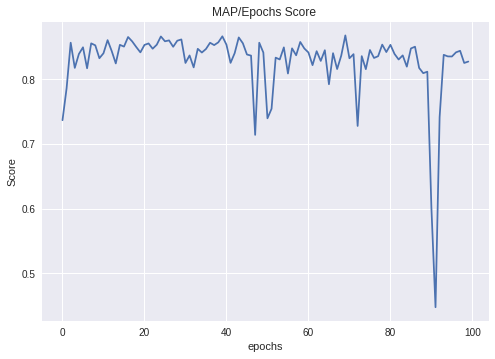

In [47]:
scores_list =  [score[0] for score in final_score] 
epochs_list = [score[1] for score in final_score] 
plt.title('MAP/Epochs Score ')
plt.ylabel('Score')
plt.xlabel('epochs')

plt.plot(epochs_list,scores_list)

In [48]:
epoch = get_best_epoch()
model.load_state_dict(torch.load(f'frcnn_best_{epoch}.pth'))

[[0.7366799839767101, 0],
 [0.7858791007121108, 1],
 [0.8563346208144581, 2],
 [0.8174358685284155, 3],
 [0.8388726422937955, 4],
 [0.8492156808579293, 5],
 [0.8168237007363995, 6],
 [0.8553237021683484, 7],
 [0.8522537412186028, 8],
 [0.8323338977813002, 9],
 [0.8400183064730927, 10],
 [0.8602727884272436, 11],
 [0.8435688900105066, 12],
 [0.8242922944734028, 13],
 [0.8530089725229644, 14],
 [0.8503089470855558, 15],
 [0.8651307447237948, 16],
 [0.8583421832204827, 17],
 [0.8496250352842637, 18],
 [0.8414057297860574, 19],
 [0.8528916694853174, 20],
 [0.8551975651031206, 21],
 [0.8470421621952126, 22],
 [0.8532295337845304, 23],
 [0.8659786573794707, 24],
 [0.8584934918060636, 25],
 [0.8598844931537482, 26],
 [0.8500066338091554, 27],
 [0.8593881910857775, 28],
 [0.8613653744008597, 29],
 [0.8250523512149054, 30],
 [0.8366395708305172, 31],
 [0.8182314596465257, 32],
 [0.846863979880962, 33],
 [0.841145077012573, 34],
 [0.846602027664543, 35],
 [0.8562343332472616, 36],
 [0.8525989883

<All keys matched successfully>

In [49]:
test_coco = './test.json'

test_dataset = myOwnDataset(root=data_dir,
                              annotation=test_coco,
                              transforms=get_transform()
                              )

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))


# own DataLoader
test_data_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=8,
                                          shuffle=False,
                                          num_workers=4,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [50]:
with torch.cuda.device('cuda:0'):
    torch.cuda.empty_cache()

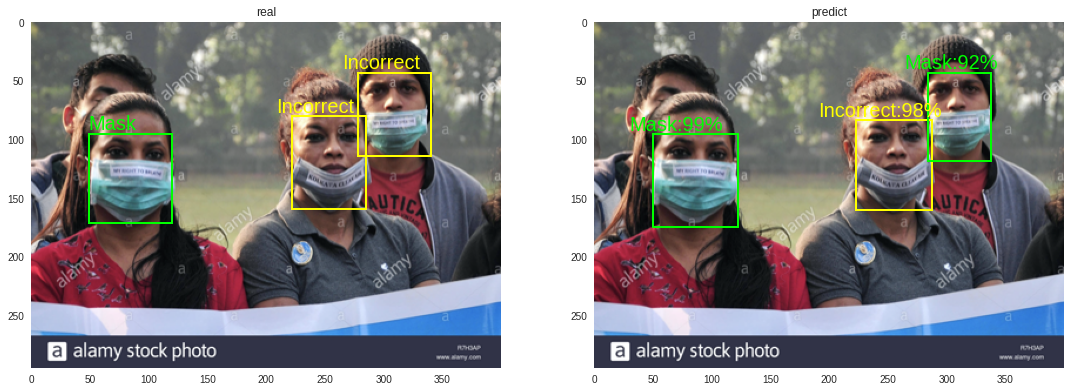

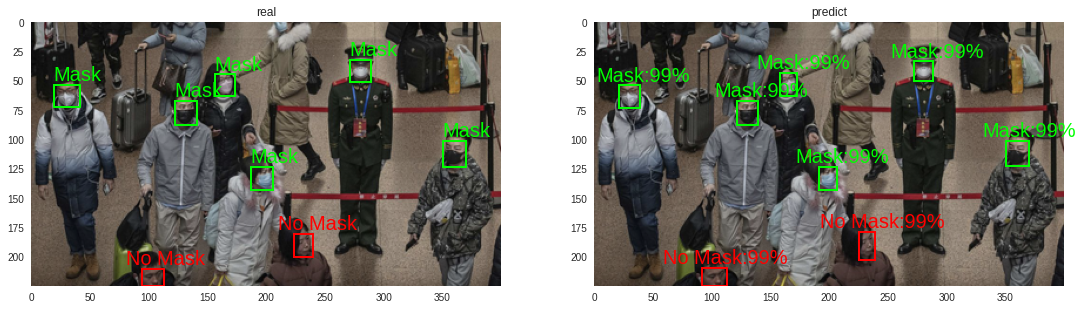

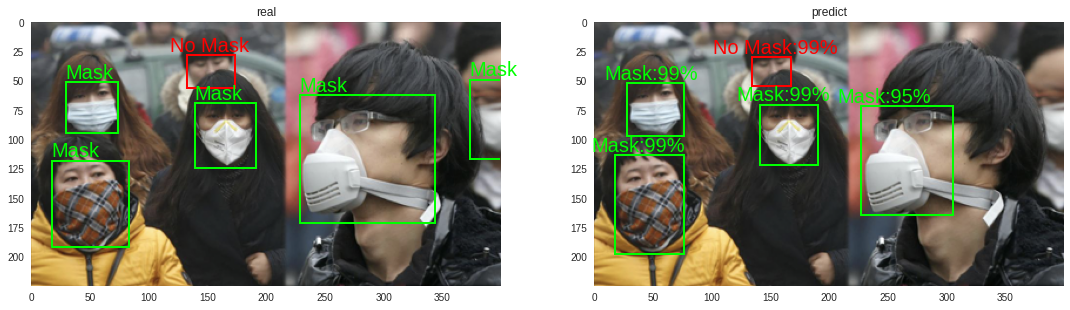

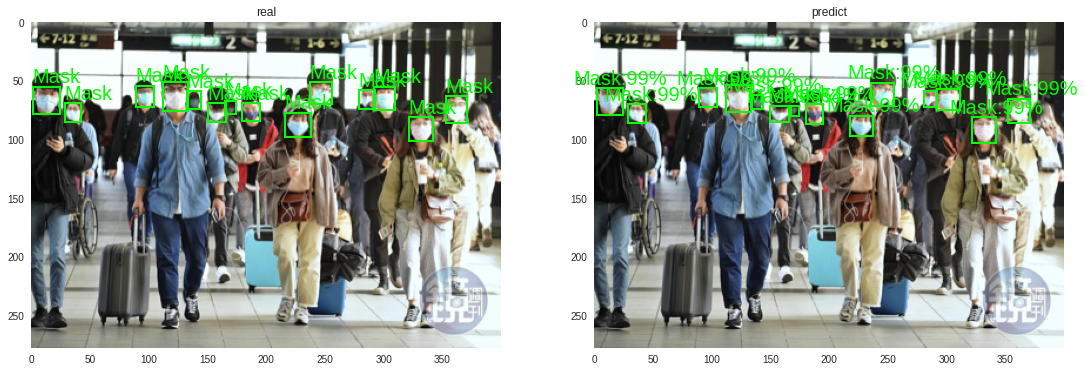

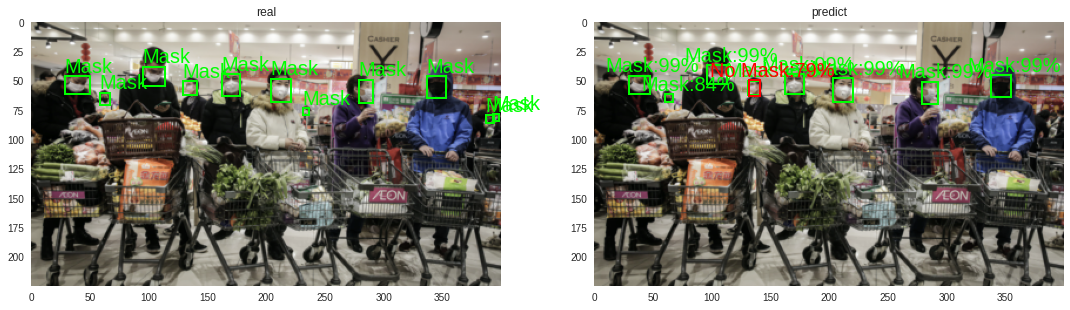

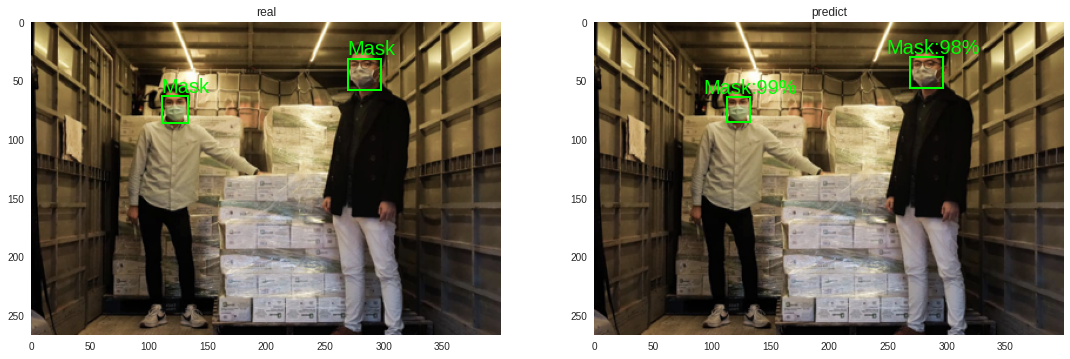

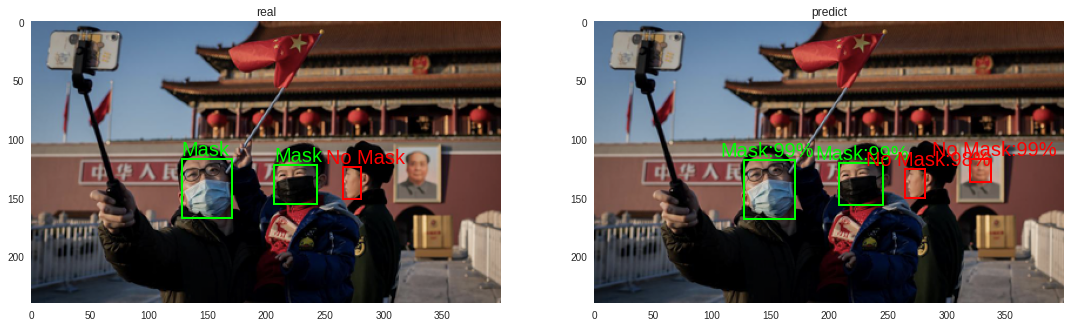

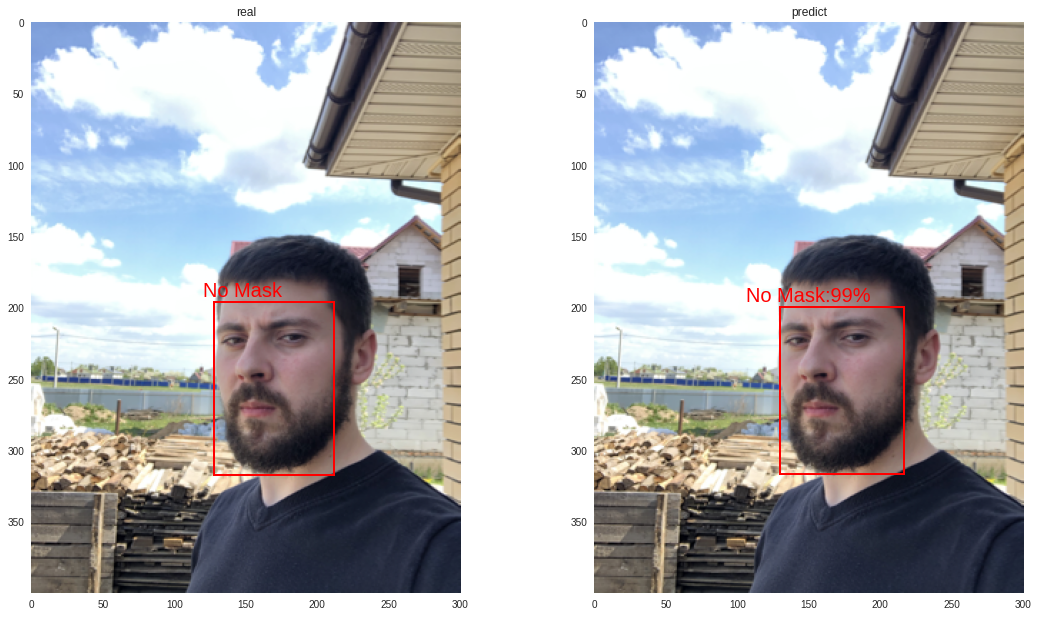

In [51]:

#get result
device = 'cuda'
model.to(device)
import matplotlib.pyplot as plt
import matplotlib.patches as patches

#Resize the batch-size to prevent out of memory
#valid_data = dataset(imgs_dir, labels_dir)
#valid_data = DataLoader(valid_data, batch_size = 4, shuffle = True,
#                       collate_fn = collate_fn)

def plot_img(img, predict, annotation) :
    mask_dic = {1:'with_mask', 2:'with_out_mask', 3:'mask_weared_incorrect'}
    fig, ax = plt.subplots(1, 2)
    
    fig.set_size_inches(18.5, 10.5)
  

    img = img.cpu().data
    ax[0].imshow(img.permute(1, 2, 0)) #rgb, w, h => w, h, rgb
    ax[1].imshow(img.permute(1, 2, 0))
    ax[0].set_title("real")
    ax[1].set_title("predict")
    ax[0].grid(False)
    ax[1].grid(False)
    for i,box in enumerate(annotation["boxes"]) :
        
        xmin, ymin, xmax, ymax = box
        label = mask_dic[int(annotation['labels'][i].data)]
        color = (0, 1, 0) # green
        text = 'Mask'
        if label == 'with_out_mask':
            color = (1, 0, 0) # red
            text = 'No Mask'
        elif label == 'mask_weared_incorrect':
            color = (1, 1, 0) # yellow
            text = 'Incorrect'
        ax[0].text(xmin+20, ymin-8, f"{text}", horizontalalignment='center', verticalalignment='center',fontsize=20,color=color)
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=2,edgecolor=color,facecolor='none')
        ax[0].add_patch(rect)
        
    for i,box in enumerate(predict["boxes"]) :
        if predict['scores'][i].item() > 0.5:
            xmin, ymin, xmax, ymax = box
            score = int((predict['scores'][i].data) * 100)
            label = mask_dic[int(predict['labels'][i].data)]
            color = (0, 1, 0) # green
            text = 'Mask'
            if label == 'with_out_mask':
                color = (1, 0, 0) # red
                text = 'No Mask'
            elif label == 'mask_weared_incorrect':
                color = (1, 1, 0) # yellow
                text = 'Incorrect'
            ax[1].text(xmin + 20, ymin - 8, f"{text}:{score}%", horizontalalignment='center', verticalalignment='center',fontsize=20,color=color)
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=2,edgecolor=color,facecolor='none')
            ax[1].add_patch(rect)
    plt.show()

model.eval()

with torch.no_grad() :
    for imgs, annotations,index in test_data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        
        prediction = model(imgs)
        
        for i in range(8) :
            plot_img(imgs[i], prediction[i], annotations[i])
            #plot_img(imgs[i], annotations[i],prediction[i])
            
        
        break
        


# **Summary**

* **At this project we examined a number of detection models, In order to identify and localize in the pictures people who wear a mask, do not wear or do not wear properly.**

* **We started by building a dirty implementation in order to find the best hyperparameters tune and then ran them on larger and deeper models and hopefully get better results, so it was.**

* **As you can see, the model can make a mistake mostly in masks that are not worn properly - increasing the amount of data in this category can solve the problem.**

* **Another diagnosis is the problematic nature of an image of a person displayed within the test image. - See the 7th test image that was displayed.**

* **We save some of our running results on Weights & Biases [account](https://wandb.ai/liortoledano/Face%20mask%20detection?workspace=user-liortoledano)**




## **Model Selection**
* **faster RCNN with different backbone - from smaller ones like mobileNet to vgg19 to resNet 50.**
* **we tried resNet101 but Unfortunately, we couldn't load the model and the data (even with super small batch size) to the GPU simultaneously.**

## **Hyperparametes search**
* **we did some testing with..**
* **Different number of epochs - 10 , 50 ,100**
* **Different learning rates: 0.01 - 0.0003.** 
* **Different optimizers: Adam & SGD - with weight decay and momentum.**

# **References**

* [EDA](https://www.kaggle.com/dodyharianto/face-mask-detection-using-cnn)
* [Data Extraction](https://www.kaggle.com/stpeteishii/face-mask-get-annotation-info-from-xml)
* [Convert to COCO format](https://github.com/roboflow-ai/voc2coco)
* [Training](https://github.com/Kaushal28/Global-Wheat-Detection)

